
CIFAR 10 with Data Augmentation and Regularization Techniques

This code defines a Vision Transformer (ViT) model using PyTorch. It includes custom components like a GELU activation function (`NewGELUActivation`), patch embedding layer (`PatchEmbeddings`), and multi-head attention mechanisms (`AttentionHead`, `MultiHeadAttention`, and `FasterMultiHeadAttention`). The model first converts images into patches, adds positional and class embeddings, and processes the input through multiple transformer blocks (`Block`). These blocks contain attention layers and feed-forward networks, with layer normalization and residual connections. Finally, the output is projected to a classification layer (`ViTForClassfication`). The model is designed for image classification tasks.

In [ ]:
import math
import torch
from torch import nn


class StochasticDepth(nn.Module):
    def __init__(self, survival_prob):
        super().__init__()
        self.survival_prob = survival_prob

    def forward(self, x):
        if not self.training or self.survival_prob == 1.0:
            return x

        batch_size = x.shape[0]
        random_tensor = torch.rand(batch_size, 1, 1, 1, device=x.device) < self.survival_prob
        return x * random_tensor / self.survival_prob
class Block(nn.Module):
    """
    A single transformer block with added stochastic depth.
    """
    def __init__(self, config, drop_path_rate=0.0):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])
        self.stochastic_depth = StochasticDepth(1 - drop_path_rate)

class NewGELUActivation(nn.Module):

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]

        self.num_patches = (self.image_size // self.patch_size) ** 2

        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):

        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)

        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))

        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)

        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x


class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size

        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]

        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.qkv_bias = config["qkv_bias"]

        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)

        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):

        attention_outputs = [head(x) for head in self.heads]

        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)

        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)

        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)


class FasterMultiHeadAttention(nn.Module):
    """
    Multi-head attention module with some optimizations.
    All the heads are processed simultaneously with merged query, key, and value projections.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]

        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.qkv_bias = config["qkv_bias"]

        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Project the query, key, and value
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, all_head_size * 3)
        qkv = self.qkv_projection(x)
        # Split the projected query, key, and value into query, key, and value
        # (batch_size, sequence_length, all_head_size * 3) -> (batch_size, sequence_length, all_head_size)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        # Resize the query, key, and value to (batch_size, num_attention_heads, sequence_length, attention_head_size)
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.attn_dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)

        attention_output = attention_output.transpose(1, 2) \
                                           .contiguous() \
                                           .view(batch_size, sequence_length, self.all_head_size)

        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)

        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)


class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])
        self.stochastic_depth = StochasticDepth(config.get("stochastic_depth_prob", 1.0))

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + self.stochastic_depth(attention_output)
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + self.stochastic_depth(mlp_output)

        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):

        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)

        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)

class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):

        embedding_output = self.embedding(x)

        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)

        logits = self.classifier(encoder_output[:, 0, :])

        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms


def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    train_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
    if train_sample_size is not None:
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)



    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)
    if test_sample_size is not None:

        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, classes


This code provides functions for managing machine learning experiments, including saving and loading model configurations, metrics, and checkpoints, and visualizing images and attention maps from a Vision Transformer (ViT) model.

1. **`save_experiment`**: Saves experiment configuration, training metrics, and the model's final state.
2. **`save_checkpoint`**: Saves the model's state dictionary at specific epochs.
3. **`load_experiment`**: Loads the experiment configuration, model, and metrics.
4. **`visualize_images`**: Displays a random selection of CIFAR-10 images.
5. **`visualize_attention`**: Visualizes the attention maps of the ViT model for 30 test images, highlighting the model's focus on different patches during classification.

In [ ]:
import json, os, math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms


def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies


def visualize_images():
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]

    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])


@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images.
    """
    model.eval()

    num_images = 30
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]

    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    images = torch.stack([test_transform(image) for image in raw_images])

    images = images.to(device)
    model = model.to(device)

    logits, attention_maps = model(images, output_attentions=True)

    predictions = torch.argmax(logits, dim=1)

    attention_maps = torch.cat(attention_maps, dim=1)

    attention_maps = attention_maps[:, :, 0, 1:]

    attention_maps = attention_maps.mean(dim=1)

    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)

    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)

    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img)

        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')

        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt==pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()


This code sets up and trains a Vision Transformer (ViT) model on the CIFAR-10 dataset for 10 epochs. It first defines the configuration for the model (e.g., hidden size, number of attention heads, and patch size). The Trainer class manages the training and evaluation process, including calculating loss and accuracy, and saving model checkpoints. In the main function, the CIFAR-10 dataset is loaded, the ViT model is instantiated, and training is started with the AdamW optimizer and cross-entropy loss. The model's performance is tracked and saved after each epoch, along with the final experiment data.

In [ ]:

exp_name = 'vit-with-10-epochs'
batch_size = 32
epochs = 10
lr = 1e-2
save_model_every = 0

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():

    save_model_every_n_epochs = save_model_every

    trainloader, testloader, _ = prepare_data(batch_size=batch_size)

    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()


100%|██████████| 170M/170M [00:04<00:00, 39.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch: 1, Train loss: 1.8865, Test loss: 1.6377, Accuracy: 0.3845
Epoch: 2, Train loss: 1.5838, Test loss: 1.5101, Accuracy: 0.4374
Epoch: 3, Train loss: 1.4721, Test loss: 1.3863, Accuracy: 0.4939
Epoch: 4, Train loss: 1.4088, Test loss: 1.3731, Accuracy: 0.4826
Epoch: 5, Train loss: 1.3677, Test loss: 1.4006, Accuracy: 0.5023
Epoch: 6, Train loss: 1.3305, Test loss: 1.3256, Accuracy: 0.5160
Epoch: 7, Train loss: 1.2984, Test loss: 1.2522, Accuracy: 0.5482
Epoch: 8, Train loss: 1.2843, Test loss: 1.2129, Accuracy: 0.5530
Epoch: 9, Train loss: 1.2372, Test loss: 1.3139, Accuracy: 0.5388
Epoch: 10, Train loss: 1.2270, Test loss: 1.1871, Accuracy: 0.5721


<ipython-input-3-532bff4c1581>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cpfile))


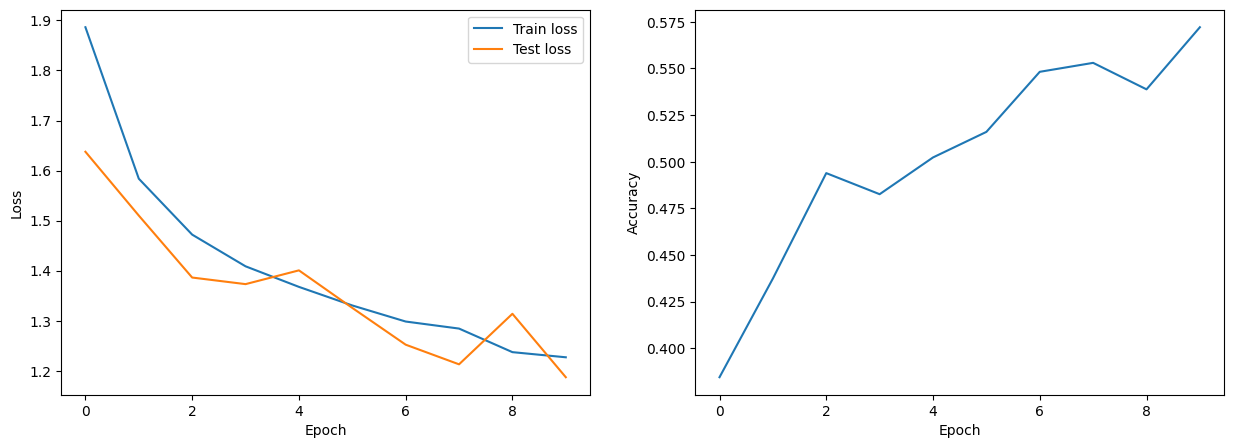

In [ ]:
config, model, train_losses, test_losses, accuracies = load_experiment(f"/content/experiments/{exp_name}/")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

MNIST with Data Augmentation, Regularization and hyperparameter tuning Techniques

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms


def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),

        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=train_transform)
    if train_sample_size is not None:

        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5,), (0.5,))
    ])

    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=test_transform)
    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)

    classes = tuple(str(i) for i in range(10))  # Classes for MNIST are digits 0-9
    return trainloader, testloader, classes


In [ ]:
import json, os, math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms


def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies


def visualize_images():
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
    classes = tuple(str(i) for i in range(10))  # Classes for MNIST: digits 0-9
    # Pick 30 samples randomly
    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]
    # Visualize the images using matplotlib
    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')  # Grayscale
        ax.set_title(classes[labels[i]])


@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images.
    """
    model.eval()
    # Load random images
    num_images = 30
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)
    classes = tuple(str(i) for i in range(10))  # Classes for MNIST: digits 0-9
    # Pick 30 samples randomly
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]
    # Convert the images to tensors
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5,), (0.5,))  # Grayscale normalization
    ])
    images = torch.stack([test_transform(image) for image in raw_images])
    # Move the images to the device
    images = images.to(device)
    model = model.to(device)
    # Get the attention maps from the last block
    logits, attention_maps = model(images, output_attentions=True)
    # Get the predictions
    predictions = torch.argmax(logits, dim=1)
    # Concatenate the attention maps from all blocks
    attention_maps = torch.cat(attention_maps, dim=1)
    # Select only the attention maps of the CLS token
    attention_maps = attention_maps[:, :, 0, 1:]
    # Then average the attention maps of the CLS token over all the heads
    attention_maps = attention_maps.mean(dim=1)
    # Reshape the attention maps to a square
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    # Resize the map to the size of the image
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    # Plot the images and the attention maps
    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img, cmap='gray')  # Grayscale
        # Mask out the attention map of the left image
        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask == 1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        # Show the ground truth and the prediction
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt == pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 142MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 13.9MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 53.7MB/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.17MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch: 1, Train loss: 2.2137, Test loss: 2.2450, Accuracy: 0.1839
Epoch: 2, Train loss: 2.2614, Test loss: 2.2887, Accuracy: 0.1451
Epoch: 3, Train loss: 2.2442, Test loss: 2.3750, Accuracy: 0.1338
Epoch: 4, Train loss: 2.7261, Test loss: 2.1124, Accuracy: 0.2463
Epoch: 5, Train loss: 2.1225, Test loss: 2.0764, Accuracy: 0.2537
Epoch: 6, Train loss: 2.1916, Test loss: 2.0959, Accuracy: 0.2268
Epoch: 7, Train loss: 2.2023, Test loss: 2.1956, Accuracy: 0.1999
Epoch: 8, Train loss: 3.1636, Test loss: 2.1801, Accuracy: 0.2069
Epoch: 9, Train loss: 2.1205, Test loss: 2.1426, Accuracy: 0.2307
Epoch: 10, Train loss: 2.1849, Test loss: 2.2341, Accuracy: 0.1725


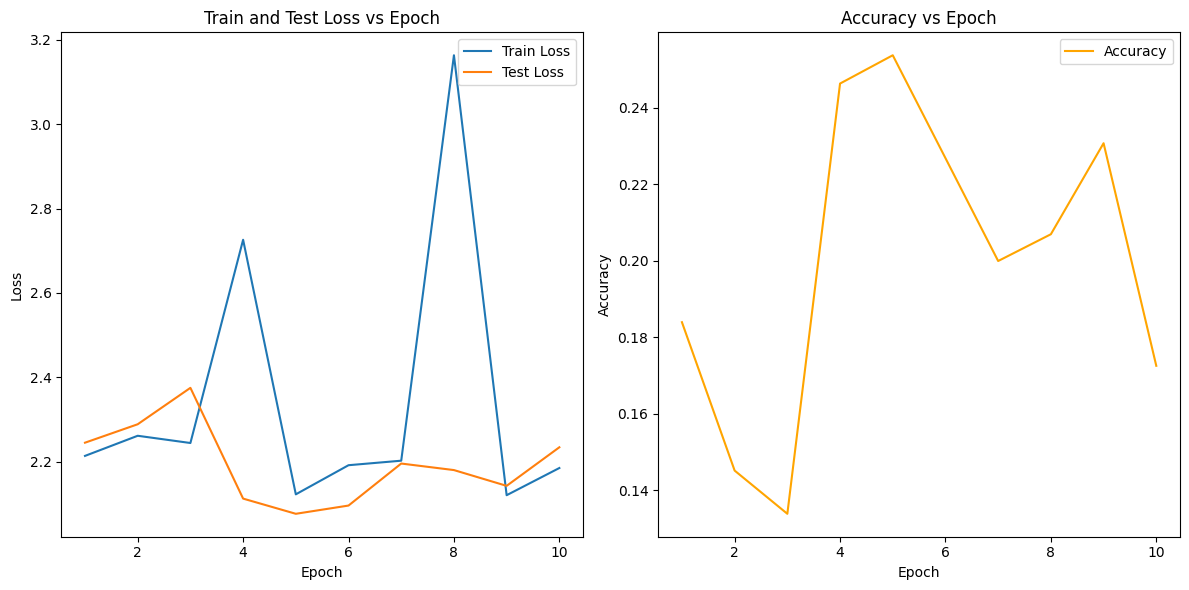

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import AdamW
import os
import matplotlib.pyplot as plt

# Hyperparameters
exp_name = 'vit-with-10-epochs'
batch_size = 32
lr = 1e-2
save_model_every = 0

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 7,  # Patch size of 7 for MNIST images of size 28x28
    "hidden_size": 64,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 64,  # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 28,  # MNIST image size
    "num_classes": 10,  # Number of classes in MNIST
    "num_channels": 1,  # MNIST images are grayscale (1 channel)
    "qkv_bias": True,
    "use_faster_attention": True,
}

# Assert to make sure configurations are valid
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class ViTForClassification(nn.Module):
    """
    Vision Transformer (ViT) Model for Image Classification.
    You would typically define the ViT architecture here.
    """

    def __init__(self, config):
        super(ViTForClassification, self).__init__()
        self.num_patches = (config['image_size'] // config['patch_size']) ** 2
        self.embedding = nn.Linear(config['patch_size'] ** 2, config['hidden_size'])
        self.attention = nn.MultiheadAttention(config['hidden_size'], config['num_attention_heads'])
        self.fc = nn.Linear(config['hidden_size'], config['num_classes'])

    def forward(self, x):
        # Implement the forward pass of ViT
        batch_size = x.size(0)
        x = x.view(batch_size, self.num_patches, -1)
        x = self.embedding(x)
        # Apply attention (this is simplified for the example)
        x, _ = self.attention(x, x, x)
        x = x.mean(dim=1)
        logits = self.fc(x)
        return logits, x


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device
        self.train_losses = []
        self.test_losses = []
        self.accuracies = []

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            self.train_losses.append(train_loss)
            self.test_losses.append(test_loss)
            self.accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                self.save_checkpoint(i+1)
        self.plot_metrics()

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            self.optimizer.zero_grad()
            loss = self.loss_fn(self.model(images)[0], labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                batch = [t.to(self.device) for t in batch]
                images, labels = batch
                logits, _ = self.model(images)
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

    def save_checkpoint(self, epoch):
        checkpoint_dir = f"./checkpoints/{self.exp_name}"
        os.makedirs(checkpoint_dir, exist_ok=True)
        checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch}.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

    def save_experiment(self, train_losses, test_losses, accuracies):
        # Save experiment details, this can be enhanced as needed
        print("Saving experiment details...")
        # Implement saving experiment results, model, etc.

    def plot_metrics(self):
        # Plot training loss, test loss, and accuracy vs epochs
        epochs = range(1, len(self.train_losses) + 1)

        # Plot loss vs epoch
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss vs Epoch')
        plt.legend()

        # Plot accuracy vs epoch
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.accuracies, label='Accuracy', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()


def prepare_data(batch_size):
    """
    Prepare MNIST dataset with the specified batch size and data augmentation.
    """
    transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomAffine(5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader


def main():
    trainloader, testloader = prepare_data(batch_size=batch_size)
    model = ViTForClassification(config)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization
    loss_fn = nn.CrossEntropyLoss()

    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every)


if __name__ == '__main__':
    main()


Fashion MNIST without hyperparameter tuning

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms


def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                 download=True, transform=train_transform)
    if train_sample_size is not None:

        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5,), (0.5,))
    ])

    testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                download=True, transform=test_transform)
    if test_sample_size is not None:

        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)

    classes = (
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    )  # Classes for Fashion MNIST
    return trainloader, testloader, classes


In [ ]:
import json
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms


def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies


def visualize_images():
    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
    classes = (
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    )  # Fashion MNIST classes

    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]

    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')
        ax.set_title(classes[labels[i]])


@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images.
    """
    model.eval()
    # Load random images
    num_images = 30
    testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)
    classes = (
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    )  # Fashion MNIST classes
    # Pick 30 samples randomly
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]
    # Convert the images to tensors
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5,), (0.5,))  # Grayscale normalization
    ])
    images = torch.stack([test_transform(image) for image in raw_images])
    # Move the images to the device
    images = images.to(device)
    model = model.to(device)
    # Get the attention maps from the last block
    logits, attention_maps = model(images, output_attentions=True)
    # Get the predictions
    predictions = torch.argmax(logits, dim=1)
    # Concatenate the attention maps from all blocks
    attention_maps = torch.cat(attention_maps, dim=1)
    # Select only the attention maps of the CLS token
    attention_maps = attention_maps[:, :, 0, 1:]
    # Then average the attention maps of the CLS token over all the heads
    attention_maps = attention_maps.mean(dim=1)
    # Reshape the attention maps to a square
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    # Resize the map to the size of the image
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    # Plot the images and the attention maps
    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img, cmap='gray')  # Grayscale
        # Mask out the attention map of the left image
        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask == 1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        # Show the ground truth and the prediction
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt == pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import AdamW
import os
import matplotlib.pyplot as plt

# Hyperparameters
exp_name = 'vit-fashion-mnist-10-epochs'  # Experiment name
batch_size = 32  # Batch size
epochs = 10  # Number of epochs
lr = 1e-2  # Learning rate
save_model_every = 0  # Save model checkpoint every N epochs (0 = don't save)

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 7,  # Patch size of 7 for 28x28 images
    "hidden_size": 64,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 64,  # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 28,  # Image size of Fashion MNIST
    "num_classes": 10,  # 10 classes in Fashion MNIST
    "num_channels": 1,  # Grayscale images
    "qkv_bias": True,
    "use_faster_attention": True,
}

# Assertions to ensure configuration validity
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class ViTForClassification(nn.Module):
    def __init__(self, config):
        super(ViTForClassification, self).__init__()
        self.num_patches = (config['image_size'] // config['patch_size']) ** 2
        self.embedding = nn.Linear(config['patch_size'] ** 2, config['hidden_size'])
        self.attention = nn.MultiheadAttention(config['hidden_size'], config['num_attention_heads'])
        self.fc = nn.Linear(config['hidden_size'], config['num_classes'])

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.num_patches, -1)
        x = self.embedding(x)
        x, _ = self.attention(x, x, x)
        x = x.mean(dim=1)
        logits = self.fc(x)
        return logits, x


class Trainer:
    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device
        self.train_losses = []
        self.test_losses = []
        self.accuracies = []

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            self.train_losses.append(train_loss)
            self.test_losses.append(test_loss)
            self.accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                self.save_checkpoint(i+1)
        self.plot_metrics()

    def train_epoch(self, trainloader):
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            self.optimizer.zero_grad()
            loss = self.loss_fn(self.model(images)[0], labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        for batch in testloader:
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            logits, _ = self.model(images)
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

    def save_checkpoint(self, epoch):
        checkpoint_dir = f"./checkpoints/{self.exp_name}"
        os.makedirs(checkpoint_dir, exist_ok=True)
        checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch}.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

    def plot_metrics(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.accuracies, label='Accuracy', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Epoch')
        plt.legend()
        plt.tight_layout()
        plt.show()


def prepare_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader


def main():
    trainloader, testloader = prepare_data(batch_size=batch_size)
    model = ViTForClassification(config)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every)

if __name__ == '__main__':
    main()


100%|██████████| 26.4M/26.4M [00:01<00:00, 21.0MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 347kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 6.26MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.36MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch: 1, Train loss: 1.6889, Test loss: 1.5661, Accuracy: 0.4076
Epoch: 2, Train loss: 2.0075, Test loss: 1.6728, Accuracy: 0.3755
Epoch: 3, Train loss: 1.8616, Test loss: 1.5854, Accuracy: 0.4222
Epoch: 4, Train loss: 2.0468, Test loss: 1.3961, Accuracy: 0.4702
Epoch: 5, Train loss: 1.7587, Test loss: 2.1504, Accuracy: 0.2030
Epoch: 6, Train loss: 1.7763, Test loss: 1.4636, Accuracy: 0.4013
Epoch: 7, Train loss: 3.2662, Test loss: 1.8175, Accuracy: 0.3320
Epoch: 8, Train loss: 1.8549, Test loss: 1.9311, Accuracy: 0.3156
Epoch: 9, Train loss: 1.7247, Test loss: 1.6367, Accuracy: 0.3904


Fashion MNIST with augmentation:

This code trains a Vision Transformer (ViT) on the Fashion MNIST dataset for 10 epochs. The `ViTForClassification` model is configured with hyperparameters like patch size, hidden size, and attention heads. The `Trainer` class handles training, evaluation, and metric tracking, including loss and accuracy. It saves checkpoints and plots training metrics. The data preparation step includes transformations for data augmentation and normalization. The model is trained using AdamW optimizer and cross-entropy loss. After training, the model’s performance is visualized using matplotlib, showing both loss and accuracy over epochs.

Epoch: 1, Train loss: 1.8184, Test loss: 2.0245, Accuracy: 0.2597
Epoch: 2, Train loss: 2.1034, Test loss: 1.9846, Accuracy: 0.2596
Epoch: 3, Train loss: 2.1263, Test loss: 2.0823, Accuracy: 0.2222
Epoch: 4, Train loss: 2.0144, Test loss: 1.7962, Accuracy: 0.3150
Epoch: 5, Train loss: 2.1439, Test loss: 1.9634, Accuracy: 0.2567
Epoch: 6, Train loss: 2.3133, Test loss: 1.8339, Accuracy: 0.3216
Epoch: 7, Train loss: 1.8786, Test loss: 1.7377, Accuracy: 0.3066
Epoch: 8, Train loss: 2.3913, Test loss: 8.6766, Accuracy: 0.1936
Epoch: 9, Train loss: 1.8757, Test loss: 1.6187, Accuracy: 0.3254
Epoch: 10, Train loss: 1.7074, Test loss: 1.7191, Accuracy: 0.3119


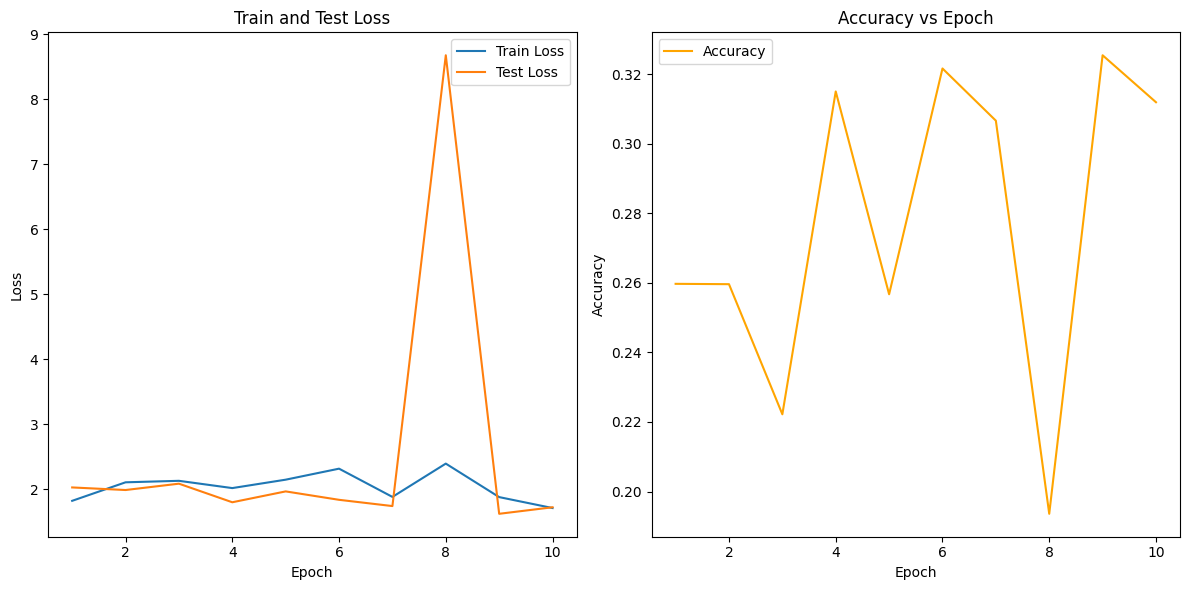

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import AdamW
import os
import matplotlib.pyplot as plt

# Hyperparameters
exp_name = 'vit-fashion-mnist-10-epochs'  # Experiment name
batch_size = 32  # Batch size
epochs = 10  # Number of epochs
lr = 1e-2  # Learning rate
save_model_every = 0  # Save model checkpoint every N epochs (0 = don't save)

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 7,  # Patch size of 7 for 28x28 images
    "hidden_size": 64,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 64,  # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 28,  # Image size of Fashion MNIST
    "num_classes": 10,  # 10 classes in Fashion MNIST
    "num_channels": 1,  # Grayscale images
    "qkv_bias": True,
    "use_faster_attention": True,
}

# Assertions to ensure configuration validity
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class ViTForClassification(nn.Module):
    def __init__(self, config):
        super(ViTForClassification, self).__init__()
        self.num_patches = (config['image_size'] // config['patch_size']) ** 2
        self.embedding = nn.Linear(config['patch_size'] ** 2, config['hidden_size'])
        self.attention = nn.MultiheadAttention(config['hidden_size'], config['num_attention_heads'])
        self.fc = nn.Linear(config['hidden_size'], config['num_classes'])

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.num_patches, -1)
        x = self.embedding(x)
        x, _ = self.attention(x, x, x)
        x = x.mean(dim=1)
        logits = self.fc(x)
        return logits, x


class Trainer:
    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device
        self.train_losses = []
        self.test_losses = []
        self.accuracies = []

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            self.train_losses.append(train_loss)
            self.test_losses.append(test_loss)
            self.accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                self.save_checkpoint(i+1)
        self.plot_metrics()

    def train_epoch(self, trainloader):
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            self.optimizer.zero_grad()
            loss = self.loss_fn(self.model(images)[0], labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        for batch in testloader:
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            logits, _ = self.model(images)
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

    def save_checkpoint(self, epoch):
        checkpoint_dir = f"./checkpoints/{self.exp_name}"
        os.makedirs(checkpoint_dir, exist_ok=True)
        checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch}.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

    def plot_metrics(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.accuracies, label='Accuracy', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Epoch')
        plt.legend()
        plt.tight_layout()
        plt.show()


def prepare_data(batch_size):
    train_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader


def main():
    trainloader, testloader = prepare_data(batch_size=batch_size)
    model = ViTForClassification(config)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every)

if __name__ == '__main__':
    main()


Fashion MNIST with hyperparameter tuning:

This code performs a grid search over hyperparameters for training a Vision Transformer (ViT) model on the Fashion MNIST dataset. The hyperparameter space includes batch size, learning rate, hidden size, number of hidden layers, and attention heads. For each combination, the model is trained using the Trainer class for 5 epochs, and its performance is evaluated on the test set. The best hyperparameter combination is determined based on accuracy. The grid_search function iterates over all possible parameter combinations, and the results are printed after completion, showing the best configuration and corresponding accuracy.

Testing params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 2}
Epoch: 1, Train loss: 1.8063, Test loss: 1.8790, Accuracy: 0.3153
Epoch: 2, Train loss: 1.8523, Test loss: 1.9199, Accuracy: 0.2707
Epoch: 3, Train loss: 2.4491, Test loss: 1.6374, Accuracy: 0.3518
Epoch: 4, Train loss: 1.7246, Test loss: 1.7080, Accuracy: 0.3676
Epoch: 5, Train loss: 1.8517, Test loss: 2.1355, Accuracy: 0.2568


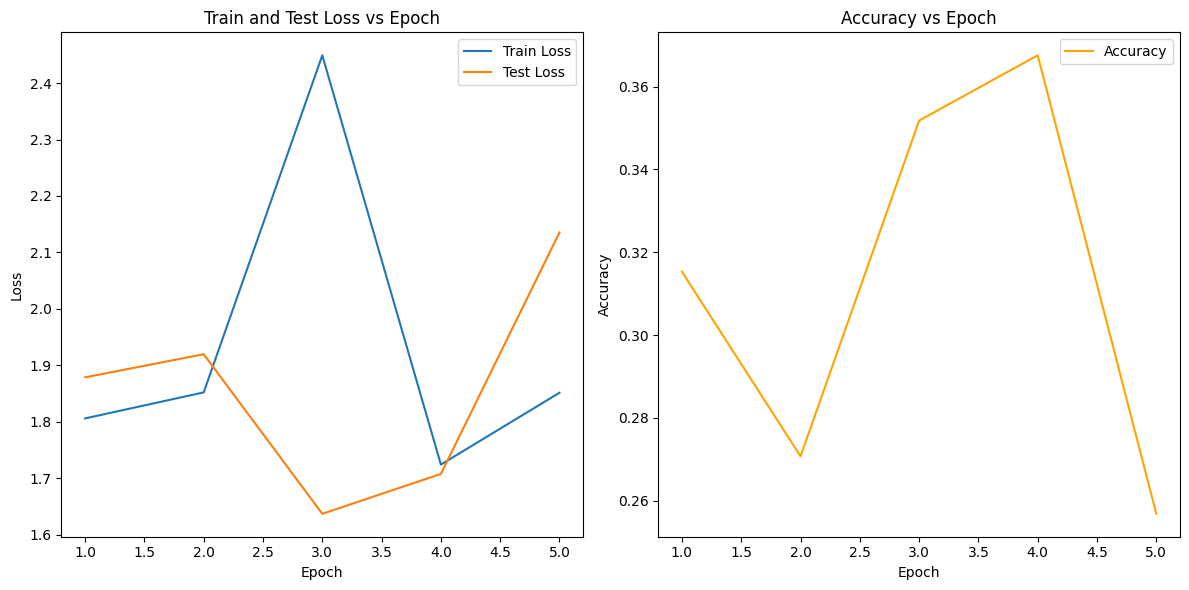

Accuracy: 0.2568
Testing params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 4}
Epoch: 1, Train loss: 1.7549, Test loss: 1.8670, Accuracy: 0.3452
Epoch: 2, Train loss: 1.9113, Test loss: 1.7685, Accuracy: 0.3403
Epoch: 3, Train loss: 1.7465, Test loss: 1.5324, Accuracy: 0.3659
Epoch: 4, Train loss: 2.2913, Test loss: 1.6744, Accuracy: 0.3622
Epoch: 5, Train loss: 1.9056, Test loss: 2.1794, Accuracy: 0.3107


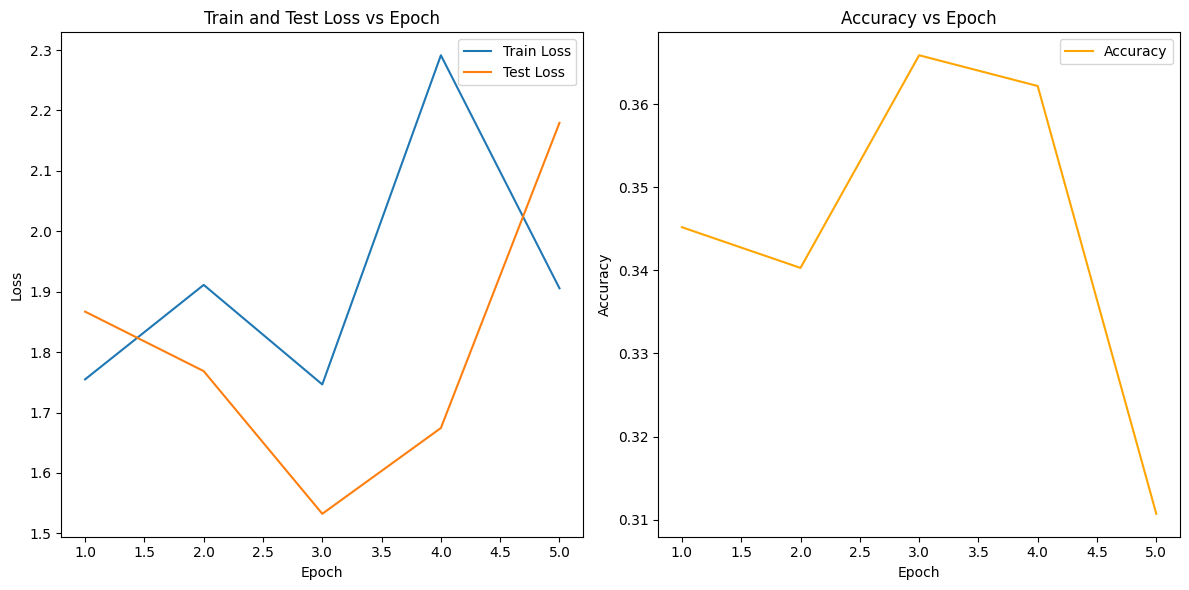

Accuracy: 0.3107
Testing params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 2}
Epoch: 1, Train loss: 1.7517, Test loss: 2.5405, Accuracy: 0.2645
Epoch: 2, Train loss: 2.4052, Test loss: 2.1297, Accuracy: 0.2085
Epoch: 3, Train loss: 1.9378, Test loss: 1.7708, Accuracy: 0.3538
Epoch: 4, Train loss: 1.8178, Test loss: 1.6884, Accuracy: 0.3665
Epoch: 5, Train loss: 1.8600, Test loss: 2.0748, Accuracy: 0.2650


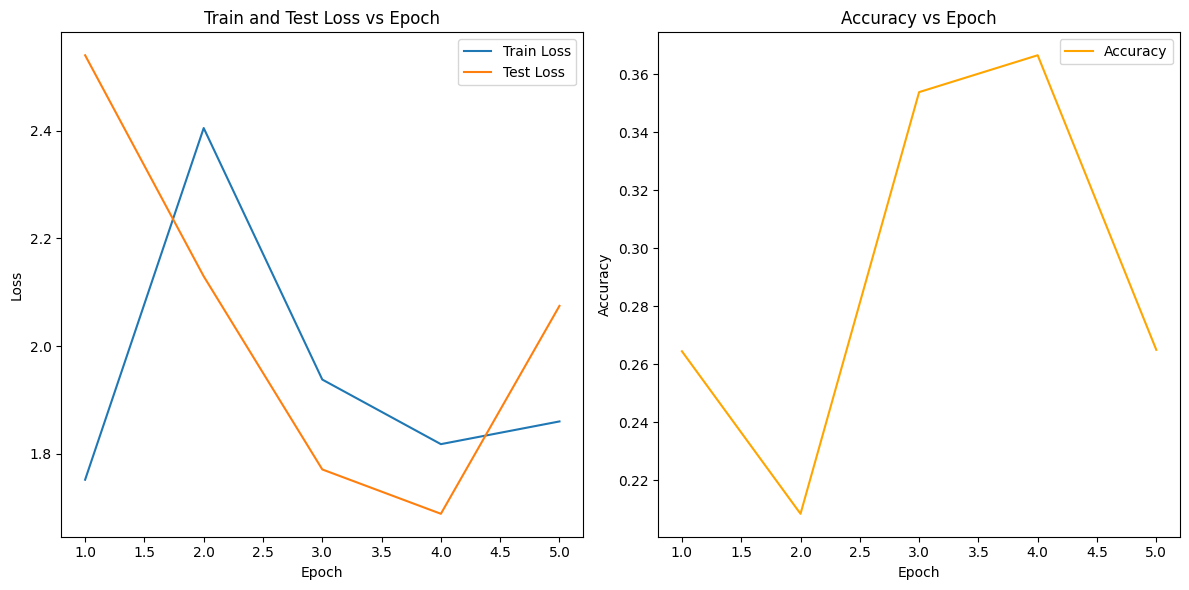

Accuracy: 0.2650
Testing params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 4}
Epoch: 1, Train loss: 1.7315, Test loss: 1.6671, Accuracy: 0.3929
Epoch: 2, Train loss: 1.9652, Test loss: 1.6267, Accuracy: 0.3539
Epoch: 3, Train loss: 2.6537, Test loss: 1.7368, Accuracy: 0.3745
Epoch: 4, Train loss: 1.5867, Test loss: 1.4140, Accuracy: 0.4574
Epoch: 5, Train loss: 1.9482, Test loss: 1.8121, Accuracy: 0.3810


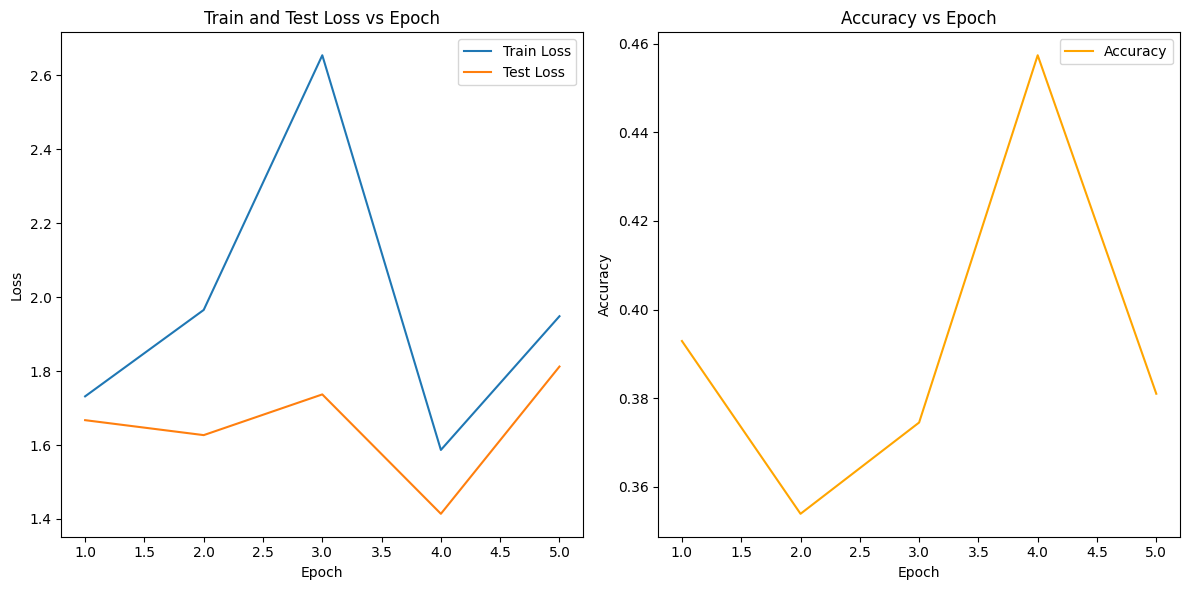

Accuracy: 0.3810
Testing params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 2}
Epoch: 1, Train loss: 3.7037, Test loss: 26.7274, Accuracy: 0.1454
Epoch: 2, Train loss: 2.8747, Test loss: 1.9893, Accuracy: 0.2388
Epoch: 3, Train loss: 1.9678, Test loss: 2.1068, Accuracy: 0.2598
Epoch: 4, Train loss: 5.0104, Test loss: 1.7973, Accuracy: 0.3130
Epoch: 5, Train loss: 2.0011, Test loss: 2.0830, Accuracy: 0.2408


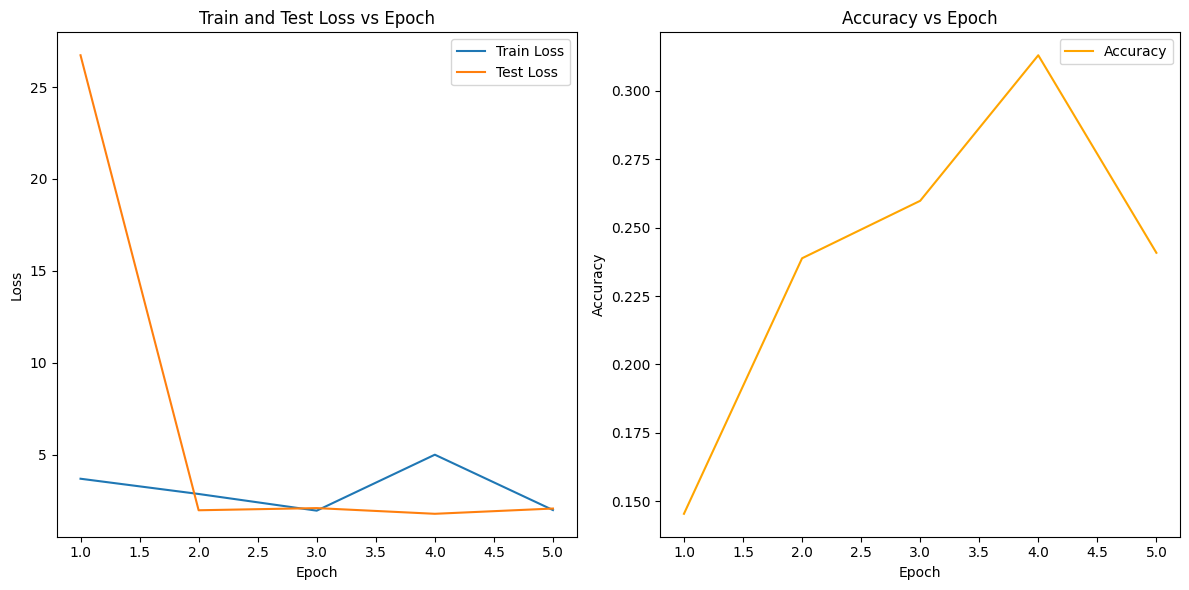

Accuracy: 0.2408
Testing params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 4}
Epoch: 1, Train loss: 2.6118, Test loss: 1.8776, Accuracy: 0.3515
Epoch: 2, Train loss: 3.2845, Test loss: 1.7395, Accuracy: 0.3724
Epoch: 3, Train loss: 1.7745, Test loss: 1.7412, Accuracy: 0.2984
Epoch: 4, Train loss: 6.6921, Test loss: 1.5955, Accuracy: 0.3946
Epoch: 5, Train loss: 1.6661, Test loss: 1.7738, Accuracy: 0.3629


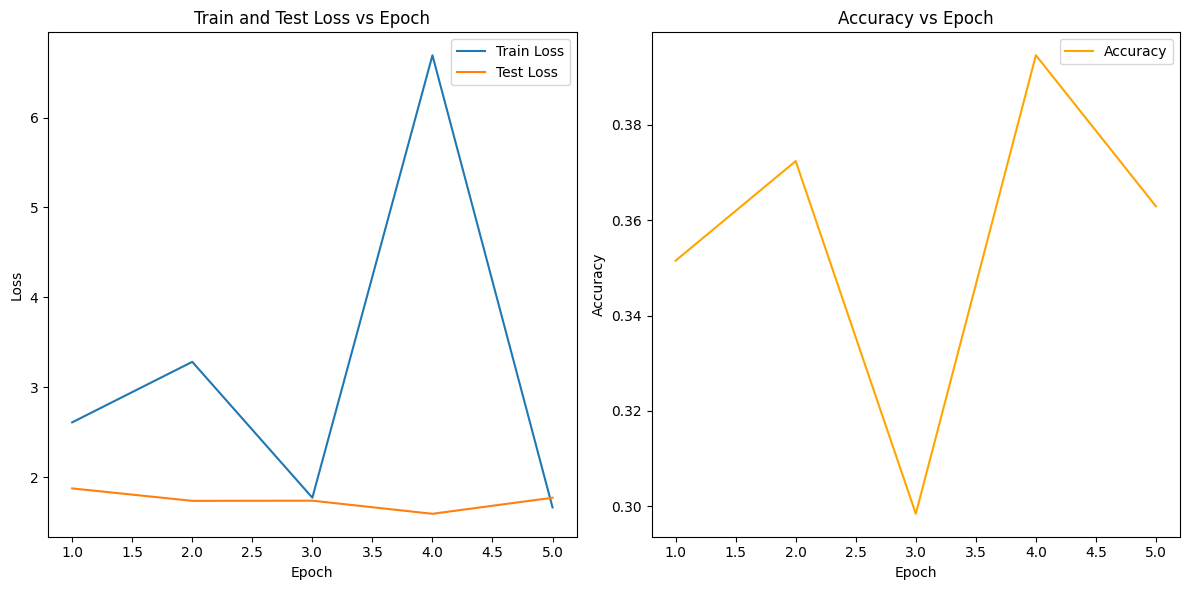

Accuracy: 0.3629
Testing params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 2}
Epoch: 1, Train loss: 3.7038, Test loss: 1.8408, Accuracy: 0.3477
Epoch: 2, Train loss: 1.7928, Test loss: 1.7052, Accuracy: 0.3631
Epoch: 3, Train loss: 10.7668, Test loss: 1.8613, Accuracy: 0.3106
Epoch: 4, Train loss: 1.8313, Test loss: 1.9371, Accuracy: 0.2745
Epoch: 5, Train loss: 1.8598, Test loss: 1.7497, Accuracy: 0.3032


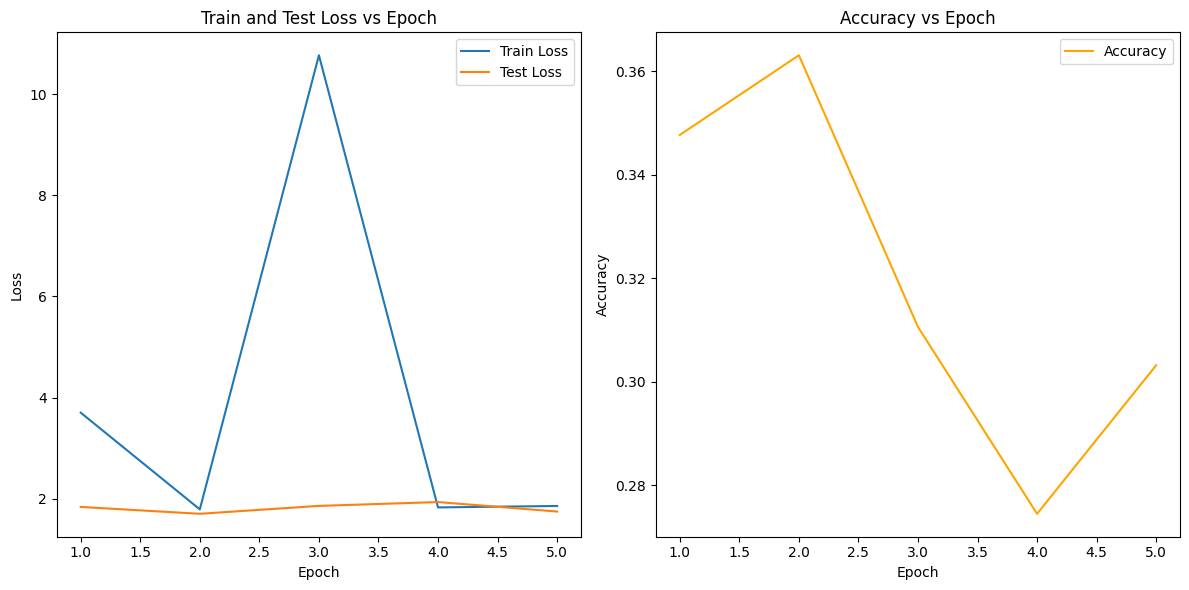

Accuracy: 0.3032
Testing params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 4}
Epoch: 1, Train loss: 4.3632, Test loss: 2.1681, Accuracy: 0.2315
Epoch: 2, Train loss: 2.0877, Test loss: 2.0198, Accuracy: 0.2564
Epoch: 3, Train loss: 9.6553, Test loss: 1.7682, Accuracy: 0.3697
Epoch: 4, Train loss: 1.6658, Test loss: 1.5952, Accuracy: 0.3882
Epoch: 5, Train loss: 1.8907, Test loss: 2.0353, Accuracy: 0.2610


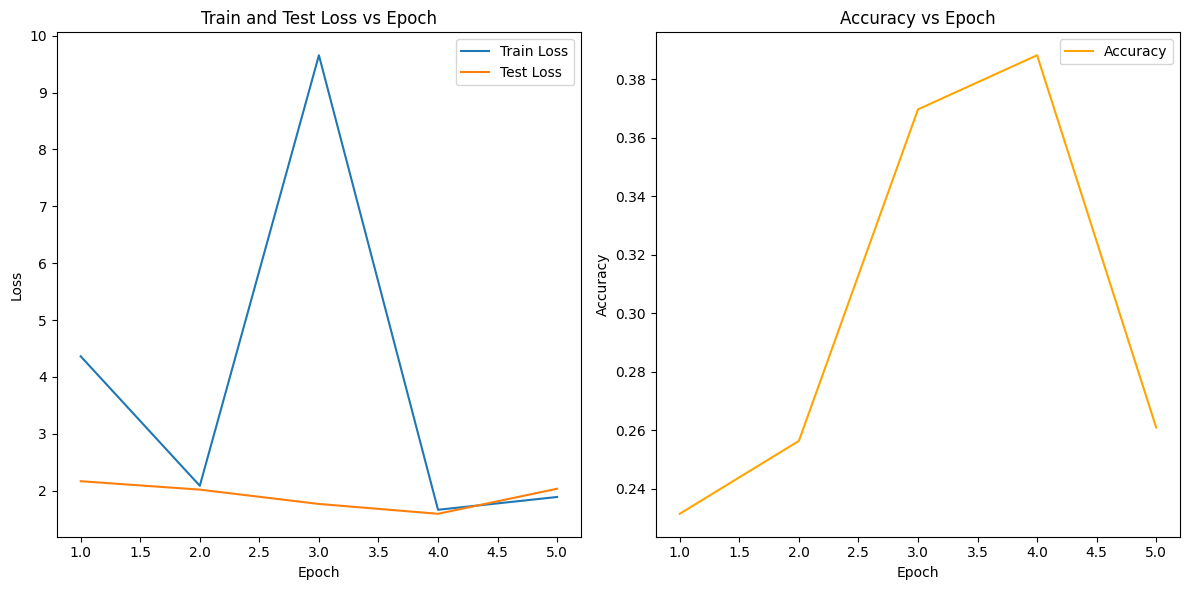

Accuracy: 0.2610
Testing params: {'batch_size': 32, 'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 2}
Epoch: 1, Train loss: 1.1666, Test loss: 1.0195, Accuracy: 0.6266
Epoch: 2, Train loss: 0.8621, Test loss: 0.7933, Accuracy: 0.7143
Epoch: 3, Train loss: 0.7836, Test loss: 0.7967, Accuracy: 0.7054
Epoch: 4, Train loss: 0.7476, Test loss: 0.8034, Accuracy: 0.7044
Epoch: 5, Train loss: 0.7201, Test loss: 0.7526, Accuracy: 0.7243


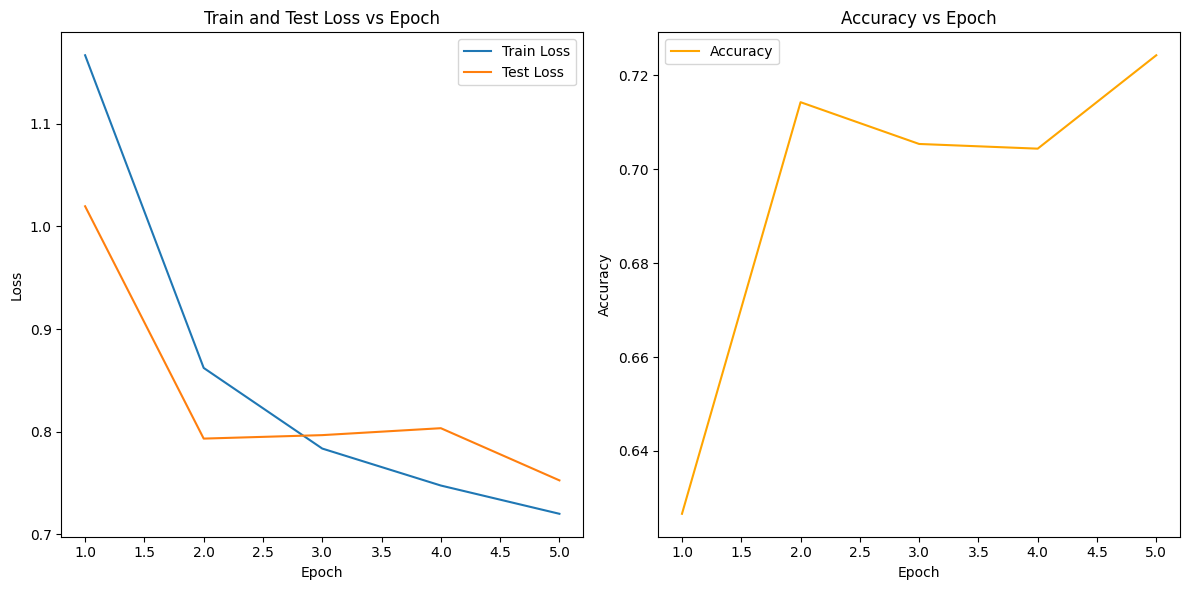

Accuracy: 0.7243
Testing params: {'batch_size': 32, 'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 4}
Epoch: 1, Train loss: 1.0686, Test loss: 0.8808, Accuracy: 0.6623
Epoch: 2, Train loss: 0.7757, Test loss: 0.7844, Accuracy: 0.7085
Epoch: 3, Train loss: 0.7087, Test loss: 0.7100, Accuracy: 0.7439
Epoch: 4, Train loss: 0.6738, Test loss: 0.7015, Accuracy: 0.7433
Epoch: 5, Train loss: 0.6442, Test loss: 0.6717, Accuracy: 0.7561


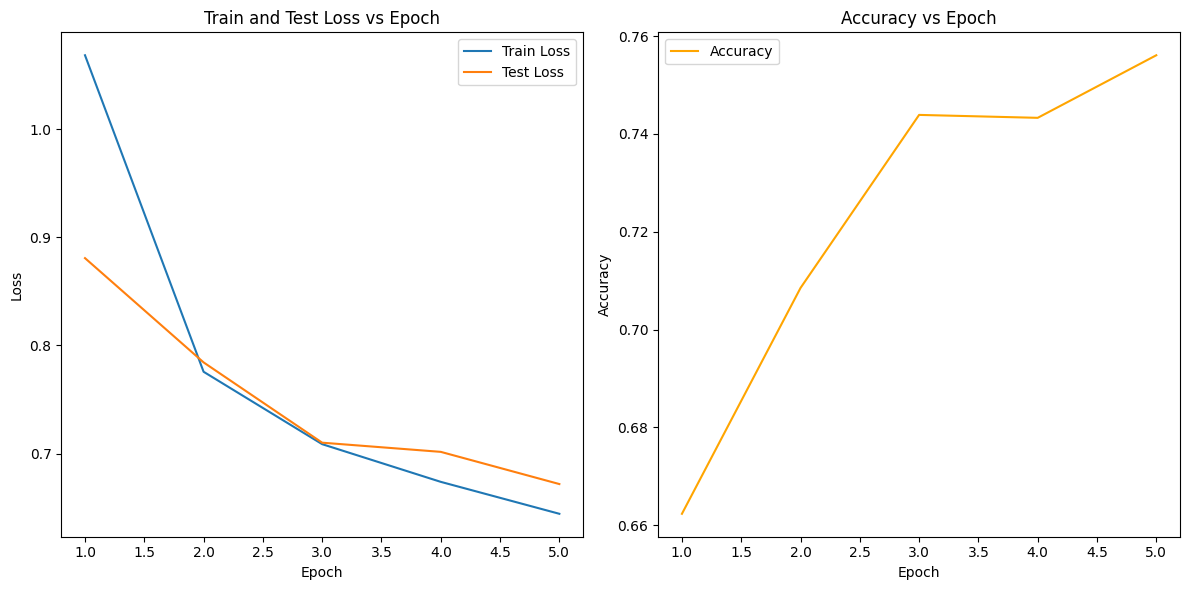

Accuracy: 0.7561
Testing params: {'batch_size': 32, 'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 2}
Epoch: 1, Train loss: 1.1487, Test loss: 0.9471, Accuracy: 0.6441
Epoch: 2, Train loss: 0.8913, Test loss: 0.8882, Accuracy: 0.6707
Epoch: 3, Train loss: 0.8071, Test loss: 0.7900, Accuracy: 0.7099
Epoch: 4, Train loss: 0.7563, Test loss: 0.7439, Accuracy: 0.7289
Epoch: 5, Train loss: 0.7258, Test loss: 0.7272, Accuracy: 0.7391


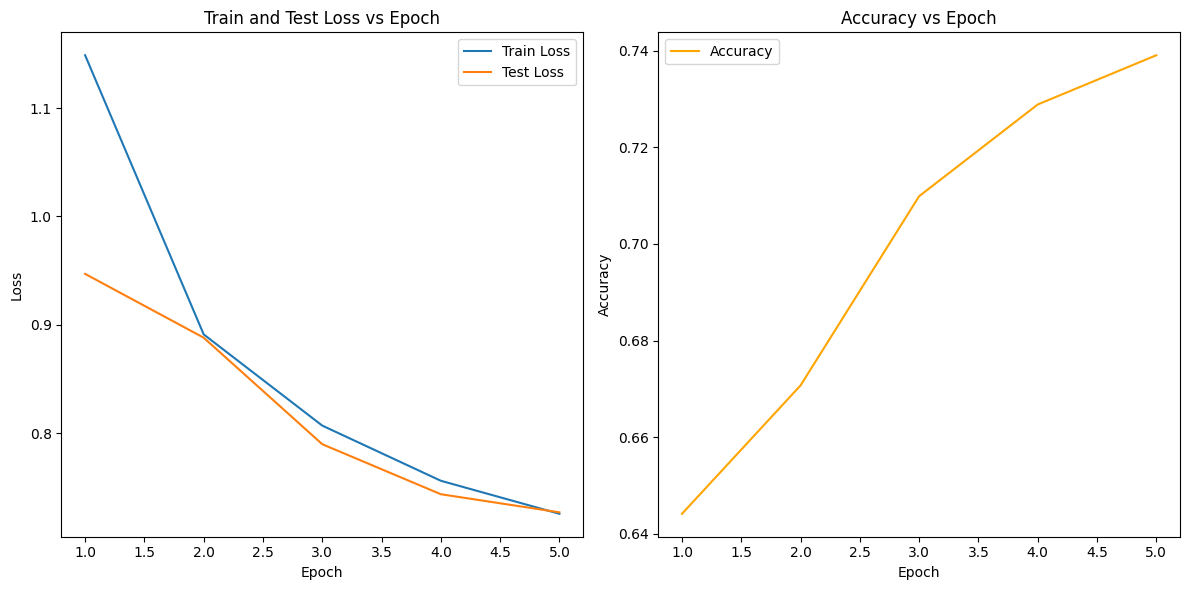

Accuracy: 0.7391
Testing params: {'batch_size': 32, 'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 4}
Epoch: 1, Train loss: 1.0812, Test loss: 0.9349, Accuracy: 0.6638
Epoch: 2, Train loss: 0.7492, Test loss: 0.7410, Accuracy: 0.7354
Epoch: 3, Train loss: 0.6894, Test loss: 0.6896, Accuracy: 0.7494
Epoch: 4, Train loss: 0.6606, Test loss: 0.6527, Accuracy: 0.7633
Epoch: 5, Train loss: 0.6311, Test loss: 0.6728, Accuracy: 0.7535


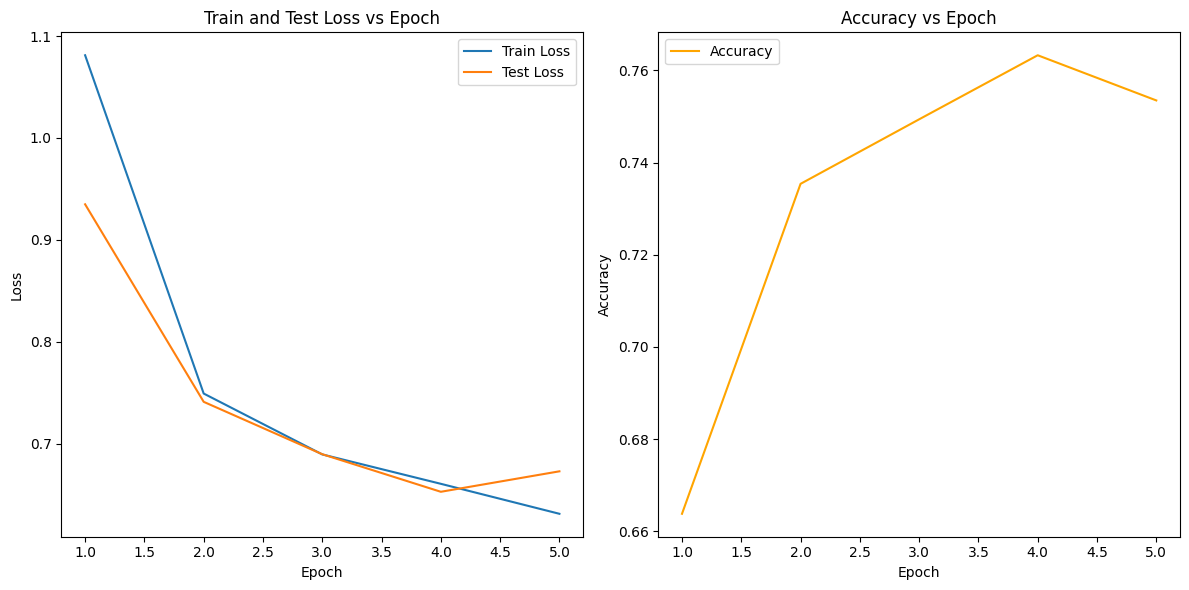

Accuracy: 0.7535
Testing params: {'batch_size': 32, 'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 2}
Epoch: 1, Train loss: 1.0514, Test loss: 0.8461, Accuracy: 0.6913
Epoch: 2, Train loss: 0.8183, Test loss: 0.7837, Accuracy: 0.7167
Epoch: 3, Train loss: 0.7710, Test loss: 0.7282, Accuracy: 0.7371
Epoch: 4, Train loss: 0.7316, Test loss: 0.7335, Accuracy: 0.7406
Epoch: 5, Train loss: 0.7114, Test loss: 0.7314, Accuracy: 0.7258


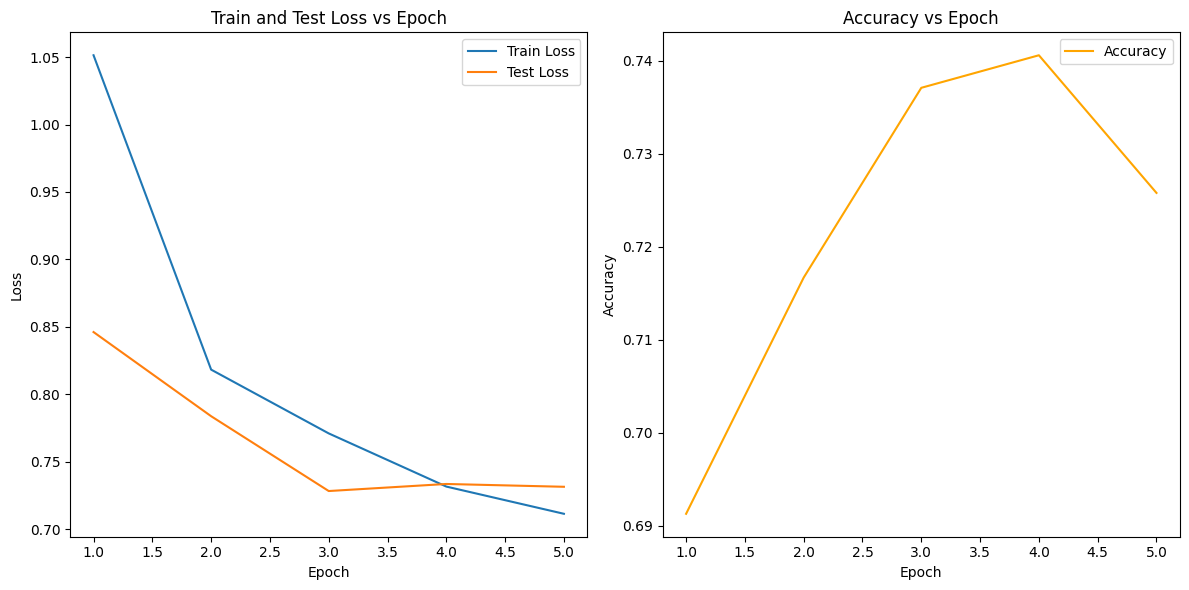

Accuracy: 0.7258
Testing params: {'batch_size': 32, 'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 4}
Epoch: 1, Train loss: 0.9741, Test loss: 0.7638, Accuracy: 0.7212
Epoch: 2, Train loss: 0.7090, Test loss: 0.6530, Accuracy: 0.7666
Epoch: 3, Train loss: 0.6501, Test loss: 0.6513, Accuracy: 0.7700
Epoch: 4, Train loss: 0.6143, Test loss: 0.6069, Accuracy: 0.7840
Epoch: 5, Train loss: 0.5971, Test loss: 0.6076, Accuracy: 0.7821


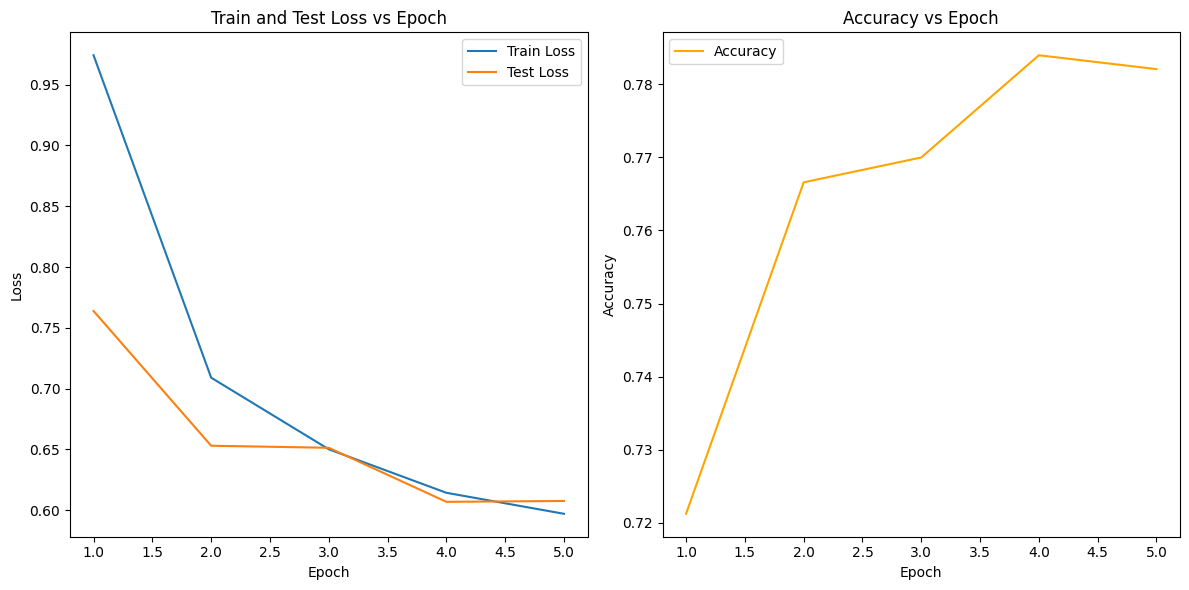

Accuracy: 0.7821
Testing params: {'batch_size': 32, 'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 2}
Epoch: 1, Train loss: 1.0326, Test loss: 0.8553, Accuracy: 0.6716
Epoch: 2, Train loss: 0.7987, Test loss: 0.7698, Accuracy: 0.7169
Epoch: 3, Train loss: 0.7484, Test loss: 0.7535, Accuracy: 0.7215
Epoch: 4, Train loss: 0.7189, Test loss: 0.7141, Accuracy: 0.7398
Epoch: 5, Train loss: 0.7040, Test loss: 0.7061, Accuracy: 0.7429


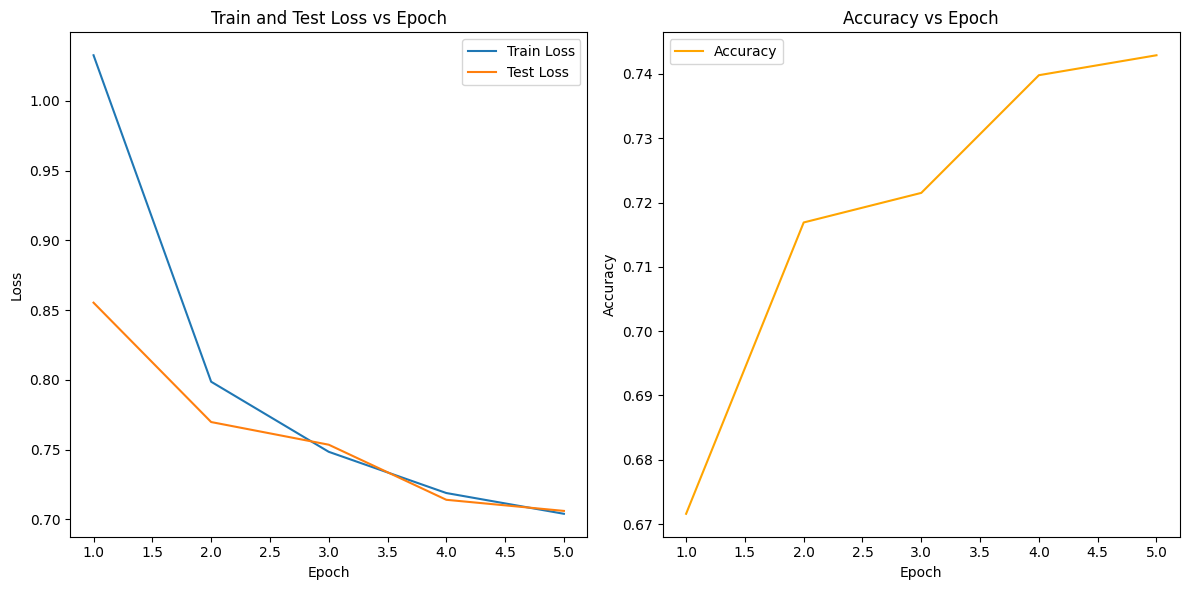

Accuracy: 0.7429
Testing params: {'batch_size': 32, 'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 4}
Epoch: 1, Train loss: 0.9481, Test loss: 0.7600, Accuracy: 0.7083
Epoch: 2, Train loss: 0.7107, Test loss: 0.7065, Accuracy: 0.7421
Epoch: 3, Train loss: 0.6526, Test loss: 0.6823, Accuracy: 0.7589
Epoch: 4, Train loss: 0.6270, Test loss: 0.6172, Accuracy: 0.7794
Epoch: 5, Train loss: 0.6043, Test loss: 0.6369, Accuracy: 0.7733


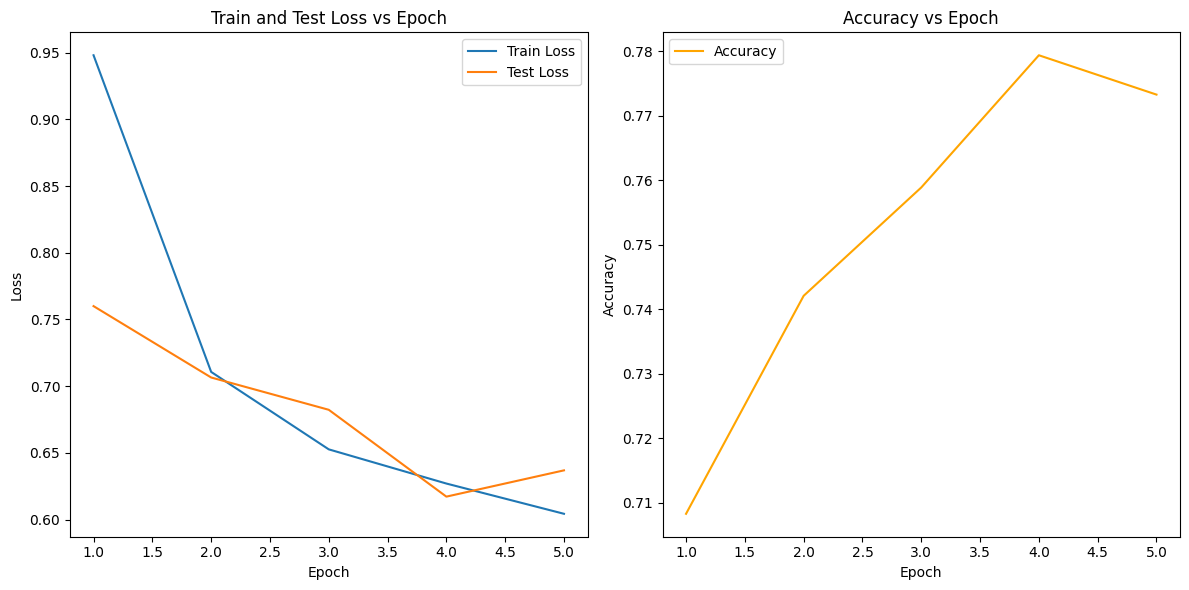

Accuracy: 0.7733
Testing params: {'batch_size': 64, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 2}
Epoch: 1, Train loss: 1.6110, Test loss: 1.7400, Accuracy: 0.3431
Epoch: 2, Train loss: 1.7243, Test loss: 1.5799, Accuracy: 0.3818
Epoch: 3, Train loss: 1.8299, Test loss: 1.7625, Accuracy: 0.3299
Epoch: 4, Train loss: 2.6547, Test loss: 1.8031, Accuracy: 0.3627
Epoch: 5, Train loss: 1.7233, Test loss: 1.7434, Accuracy: 0.3900


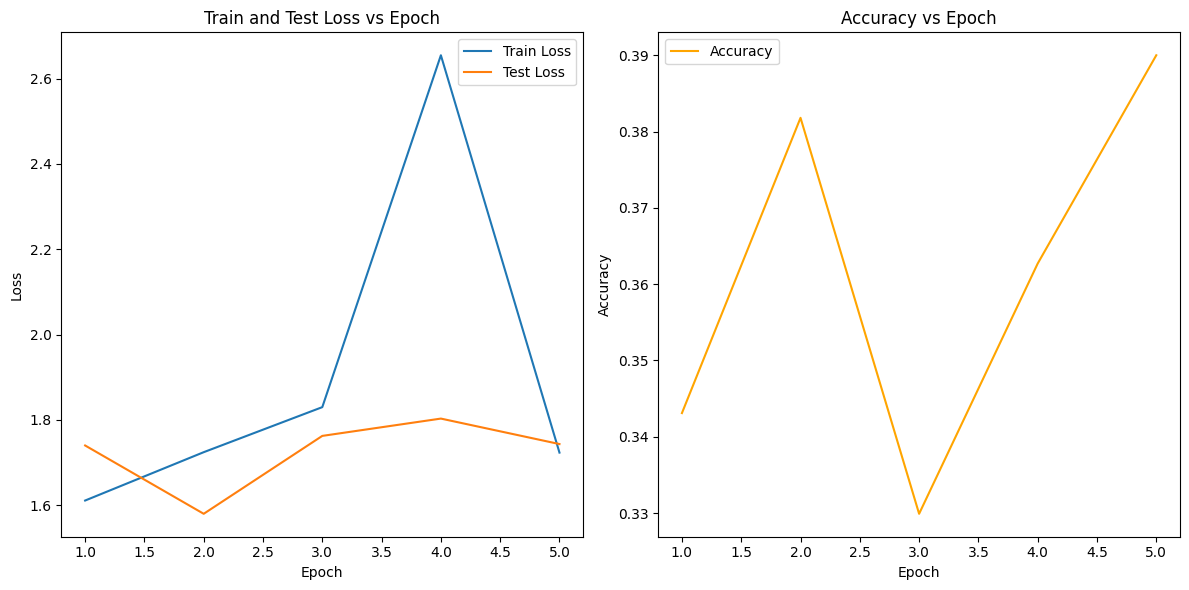

Accuracy: 0.3900
Testing params: {'batch_size': 64, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 4}
Epoch: 1, Train loss: 1.4694, Test loss: 1.5734, Accuracy: 0.4029
Epoch: 2, Train loss: 1.7181, Test loss: 1.7049, Accuracy: 0.3797
Epoch: 3, Train loss: 1.6239, Test loss: 1.3865, Accuracy: 0.4847
Epoch: 4, Train loss: 1.5436, Test loss: 1.7951, Accuracy: 0.3662
Epoch: 5, Train loss: 1.7698, Test loss: 1.5502, Accuracy: 0.4323


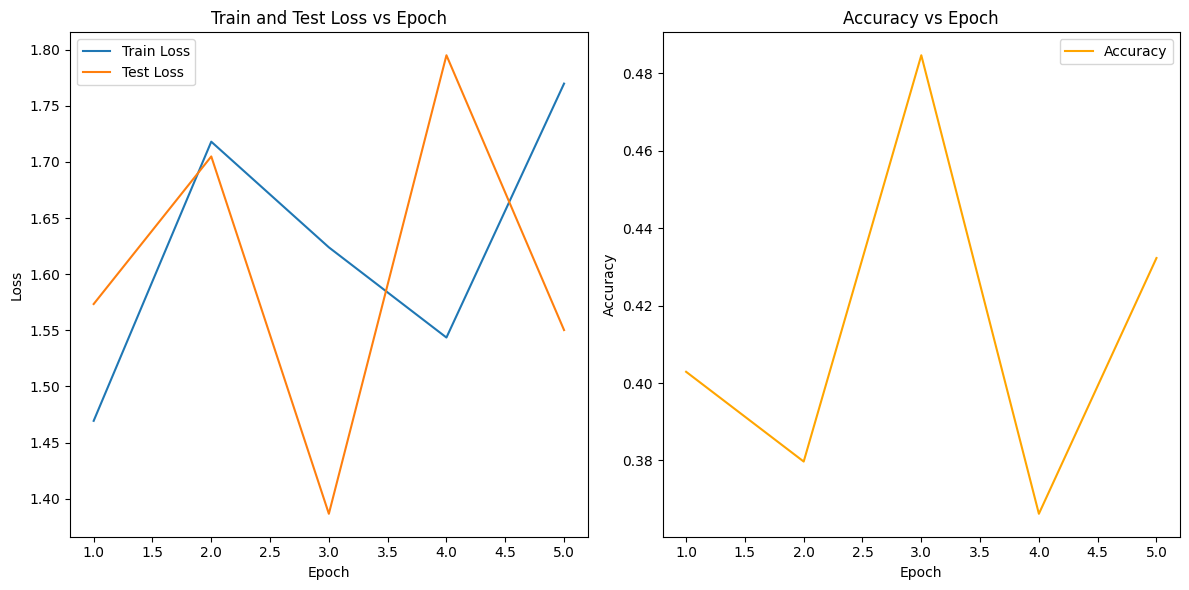

Accuracy: 0.4323
Testing params: {'batch_size': 64, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 2}
Epoch: 1, Train loss: 1.5287, Test loss: 1.7285, Accuracy: 0.3751
Epoch: 2, Train loss: 1.7994, Test loss: 1.8909, Accuracy: 0.2478
Epoch: 3, Train loss: 1.6711, Test loss: 2.5531, Accuracy: 0.2106
Epoch: 4, Train loss: 2.0806, Test loss: 6.1869, Accuracy: 0.2315
Epoch: 5, Train loss: 2.1489, Test loss: 1.7765, Accuracy: 0.2913


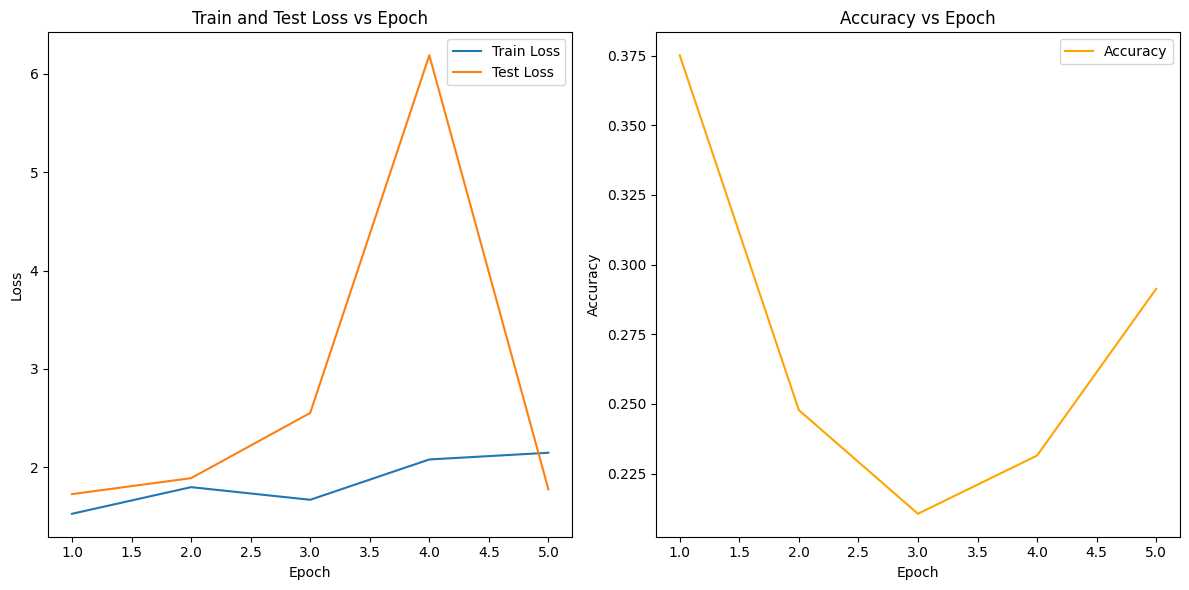

Accuracy: 0.2913
Testing params: {'batch_size': 64, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 4}
Epoch: 1, Train loss: 1.3759, Test loss: 1.2748, Accuracy: 0.5065
Epoch: 2, Train loss: 1.5190, Test loss: 1.7356, Accuracy: 0.3658
Epoch: 3, Train loss: 1.6351, Test loss: 2.0171, Accuracy: 0.3091
Epoch: 4, Train loss: 1.4939, Test loss: 1.7912, Accuracy: 0.3404
Epoch: 5, Train loss: 1.5814, Test loss: 1.4988, Accuracy: 0.4406


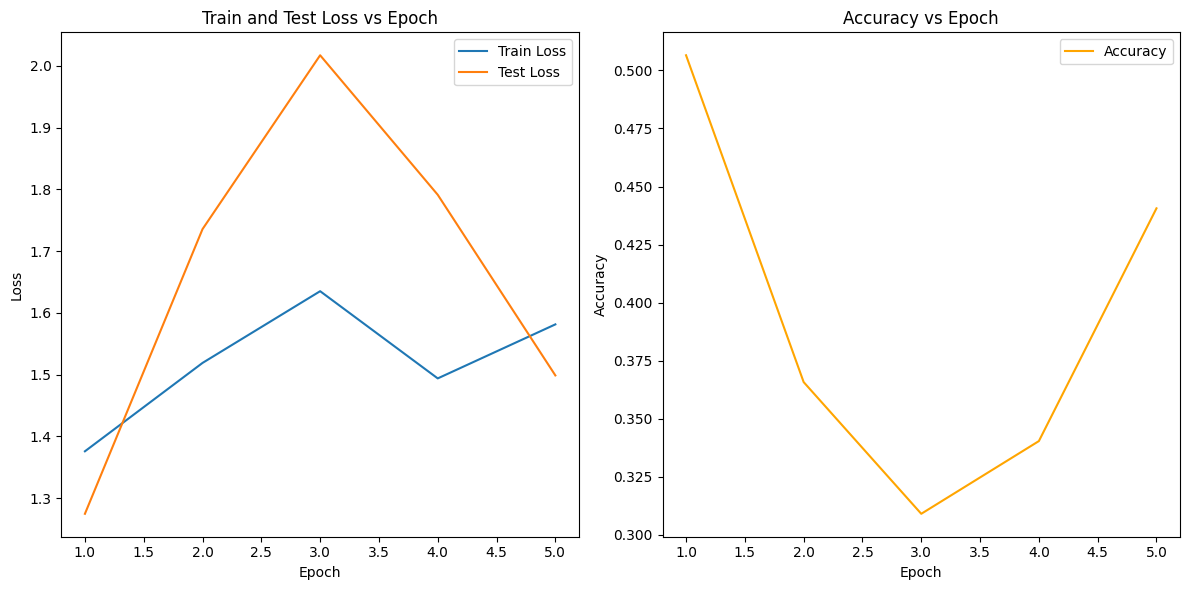

Accuracy: 0.4406
Testing params: {'batch_size': 64, 'lr': 0.01, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 2}
Epoch: 1, Train loss: 2.8045, Test loss: 1.5369, Accuracy: 0.4071
Epoch: 2, Train loss: 6.4934, Test loss: 1.7544, Accuracy: 0.3019
Epoch: 3, Train loss: 1.7764, Test loss: 1.6975, Accuracy: 0.3314
Epoch: 4, Train loss: 1.7234, Test loss: 1.7440, Accuracy: 0.3388
Epoch: 5, Train loss: 1.9732, Test loss: 1.9397, Accuracy: 0.2768


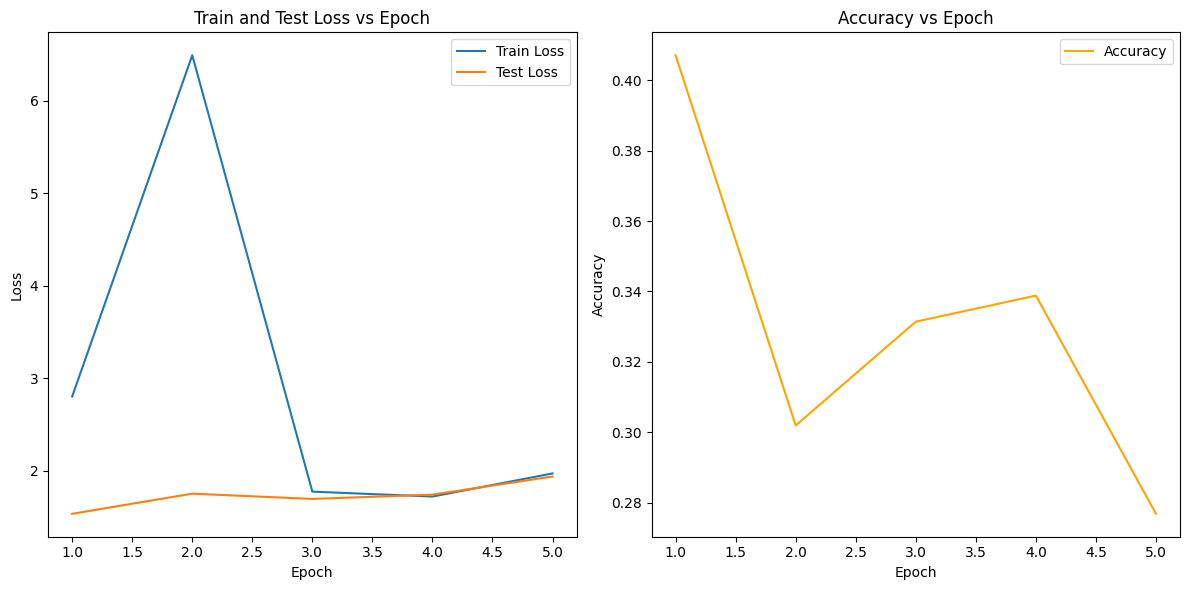

Accuracy: 0.2768
Testing params: {'batch_size': 64, 'lr': 0.01, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 4}
Epoch: 1, Train loss: 1.9869, Test loss: 3.6185, Accuracy: 0.1951
Epoch: 2, Train loss: 2.3485, Test loss: 8.2602, Accuracy: 0.1926
Epoch: 3, Train loss: 2.1530, Test loss: 1.6660, Accuracy: 0.3784
Epoch: 4, Train loss: 12.1338, Test loss: 1.8253, Accuracy: 0.3445
Epoch: 5, Train loss: 1.8531, Test loss: 2.0270, Accuracy: 0.2873


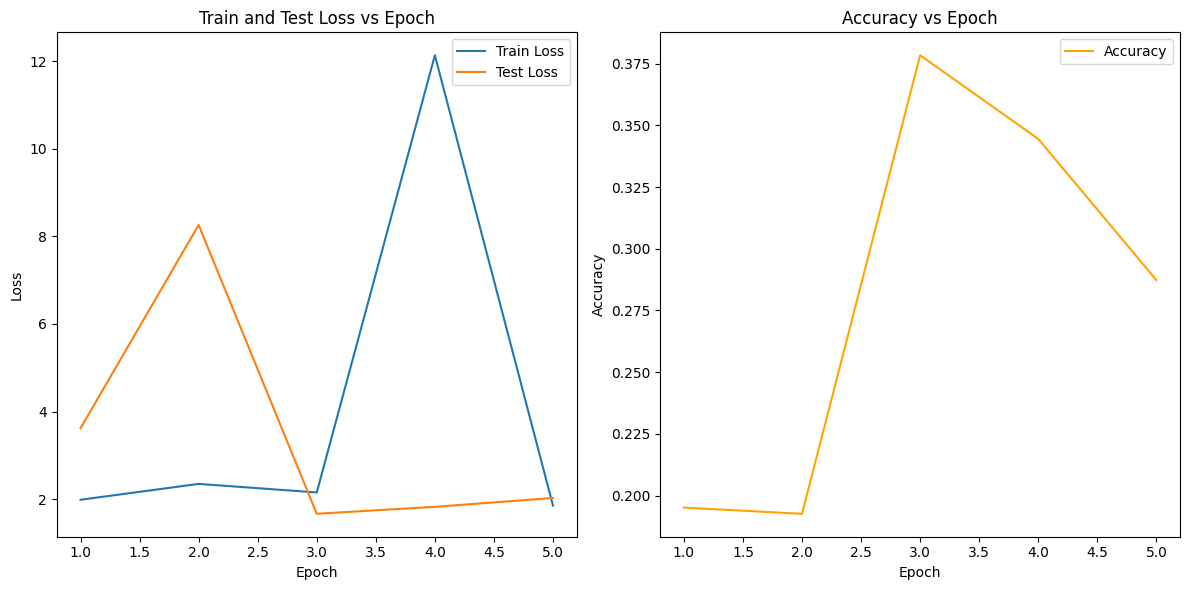

Accuracy: 0.2873
Testing params: {'batch_size': 64, 'lr': 0.01, 'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 2}
Epoch: 1, Train loss: 3.2987, Test loss: 2.0370, Accuracy: 0.2584
Epoch: 2, Train loss: 1.9267, Test loss: 1.8891, Accuracy: 0.3140
Epoch: 3, Train loss: 1.9254, Test loss: 2.0108, Accuracy: 0.2507
Epoch: 4, Train loss: 1.9510, Test loss: 1.9206, Accuracy: 0.2639
Epoch: 5, Train loss: 4.2142, Test loss: 1.7611, Accuracy: 0.2693


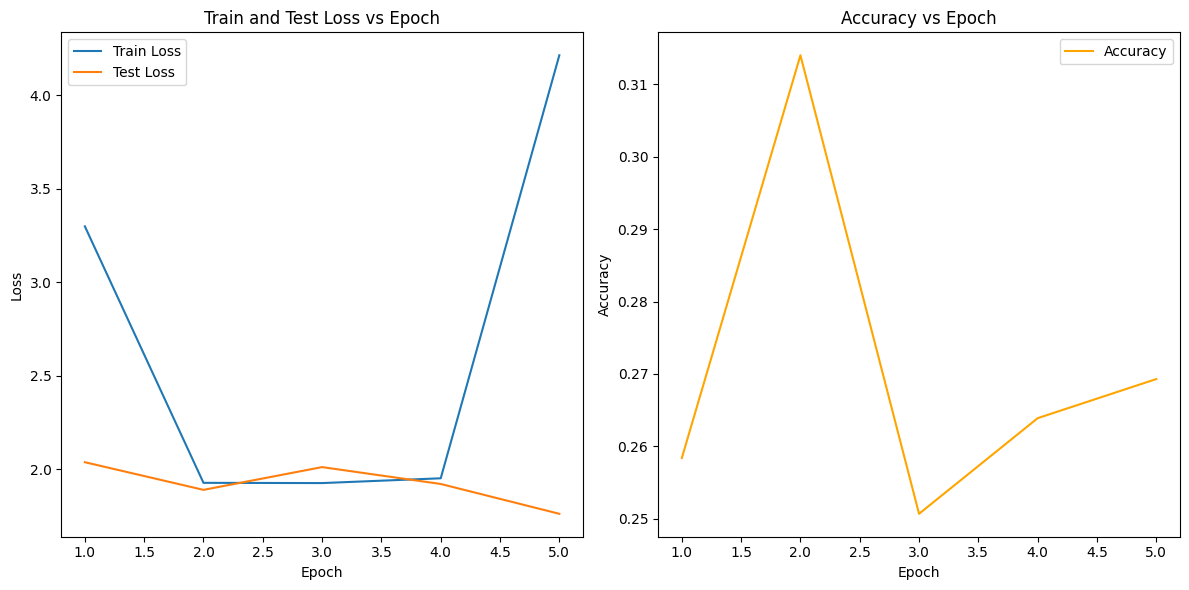

Accuracy: 0.2693
Testing params: {'batch_size': 64, 'lr': 0.01, 'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 4}
Epoch: 1, Train loss: 1.8620, Test loss: 2.0586, Accuracy: 0.2743
Epoch: 2, Train loss: 2.5440, Test loss: 1.6369, Accuracy: 0.3908
Epoch: 3, Train loss: 4.5704, Test loss: 1.5868, Accuracy: 0.3879
Epoch: 4, Train loss: 1.7289, Test loss: 1.9012, Accuracy: 0.2933
Epoch: 5, Train loss: 1.7957, Test loss: 1.7718, Accuracy: 0.3371


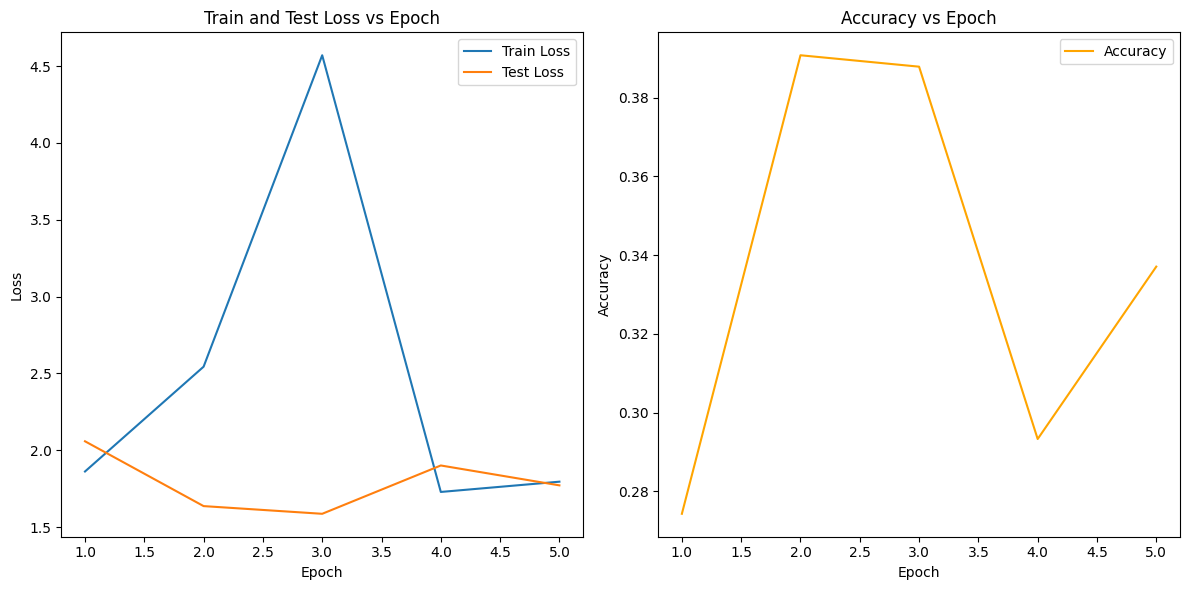

Accuracy: 0.3371
Testing params: {'batch_size': 64, 'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 2}
Epoch: 1, Train loss: 1.2315, Test loss: 1.0056, Accuracy: 0.6333
Epoch: 2, Train loss: 0.9055, Test loss: 0.8506, Accuracy: 0.6894
Epoch: 3, Train loss: 0.7969, Test loss: 0.7909, Accuracy: 0.7122
Epoch: 4, Train loss: 0.7532, Test loss: 0.7419, Accuracy: 0.7287
Epoch: 5, Train loss: 0.7177, Test loss: 0.7129, Accuracy: 0.7441


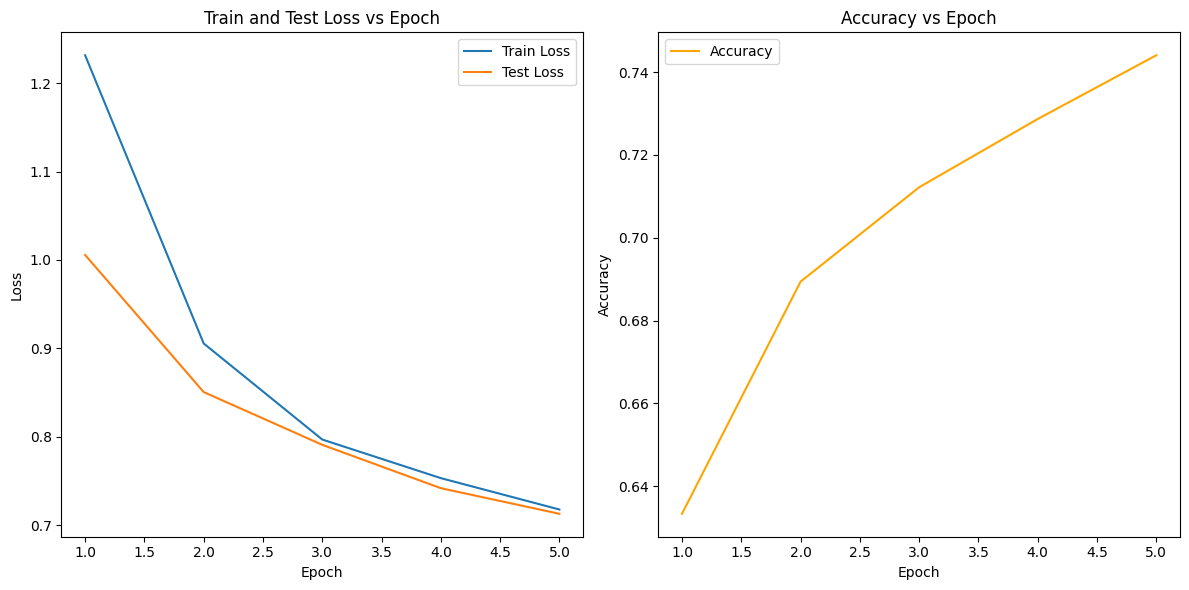

Accuracy: 0.7441
Testing params: {'batch_size': 64, 'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 4}
Epoch: 1, Train loss: 1.1515, Test loss: 0.8942, Accuracy: 0.6723
Epoch: 2, Train loss: 0.7997, Test loss: 0.7617, Accuracy: 0.7164
Epoch: 3, Train loss: 0.7238, Test loss: 0.7191, Accuracy: 0.7400
Epoch: 4, Train loss: 0.6820, Test loss: 0.6937, Accuracy: 0.7479
Epoch: 5, Train loss: 0.6486, Test loss: 0.6716, Accuracy: 0.7474


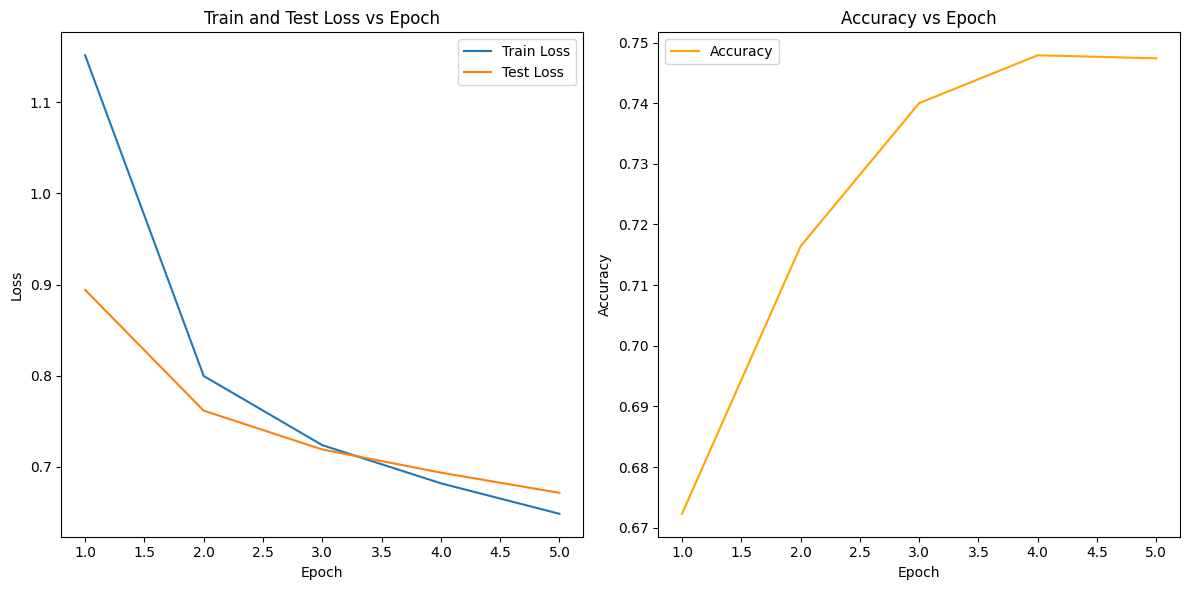

Accuracy: 0.7474
Testing params: {'batch_size': 64, 'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 2}
Epoch: 1, Train loss: 1.3282, Test loss: 1.0720, Accuracy: 0.5915
Epoch: 2, Train loss: 0.9226, Test loss: 0.8548, Accuracy: 0.6822
Epoch: 3, Train loss: 0.8123, Test loss: 0.7690, Accuracy: 0.7208
Epoch: 4, Train loss: 0.7609, Test loss: 0.7501, Accuracy: 0.7236
Epoch: 5, Train loss: 0.7239, Test loss: 0.7386, Accuracy: 0.7290


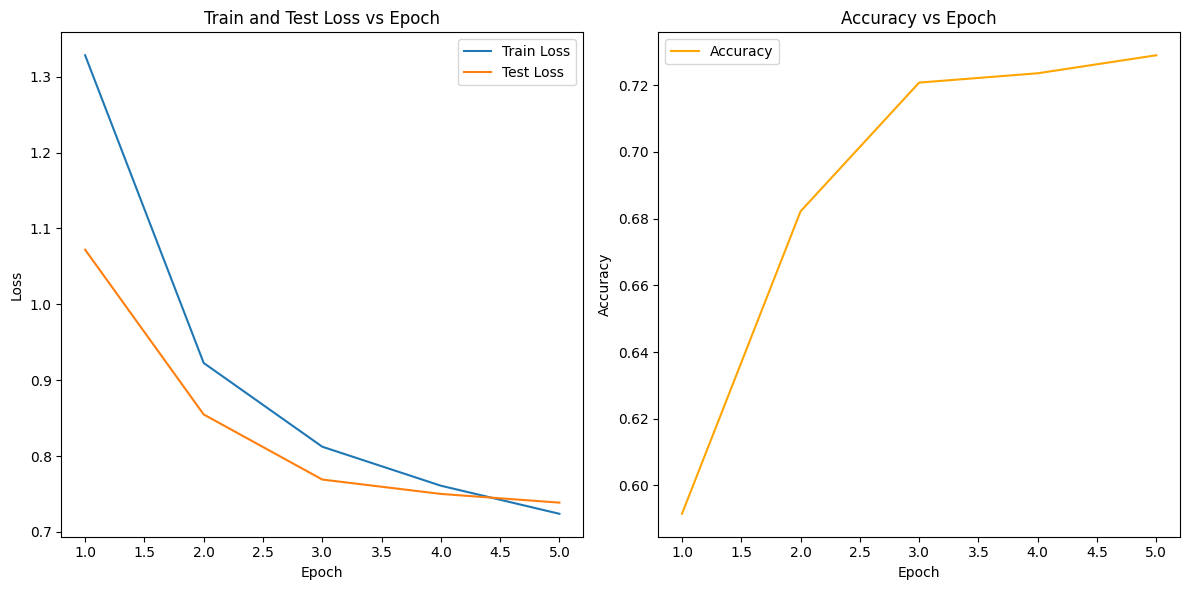

Accuracy: 0.7290
Testing params: {'batch_size': 64, 'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 4}
Epoch: 1, Train loss: 1.1556, Test loss: 0.9041, Accuracy: 0.6608
Epoch: 2, Train loss: 0.7876, Test loss: 0.7777, Accuracy: 0.7206
Epoch: 3, Train loss: 0.7054, Test loss: 0.6981, Accuracy: 0.7452
Epoch: 4, Train loss: 0.6616, Test loss: 0.6424, Accuracy: 0.7696
Epoch: 5, Train loss: 0.6346, Test loss: 0.6422, Accuracy: 0.7694


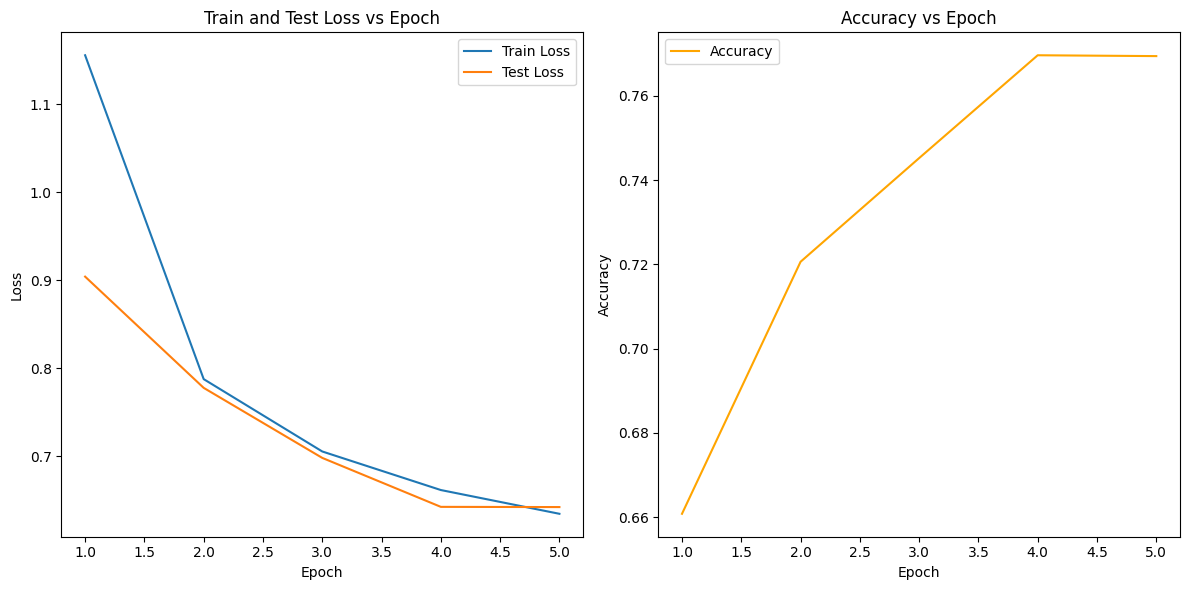

Accuracy: 0.7694
Testing params: {'batch_size': 64, 'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 2}
Epoch: 1, Train loss: 1.1329, Test loss: 0.8500, Accuracy: 0.6886
Epoch: 2, Train loss: 0.7837, Test loss: 0.7214, Accuracy: 0.7428
Epoch: 3, Train loss: 0.7040, Test loss: 0.7122, Accuracy: 0.7437
Epoch: 4, Train loss: 0.6747, Test loss: 0.6618, Accuracy: 0.7628
Epoch: 5, Train loss: 0.6470, Test loss: 0.7251, Accuracy: 0.7260


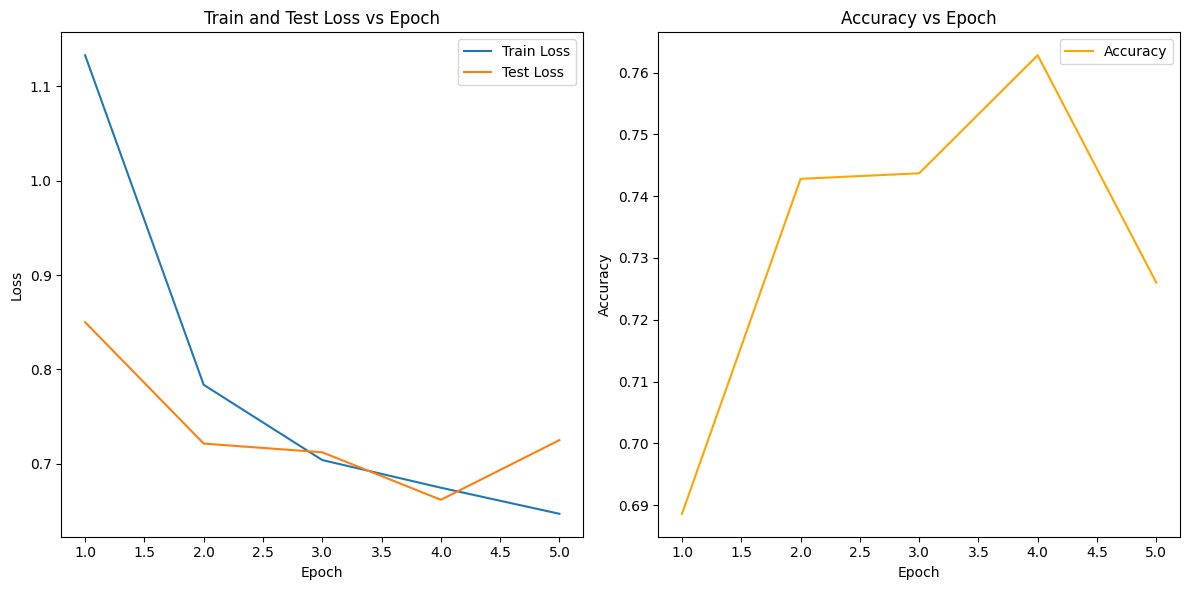

Accuracy: 0.7260
Testing params: {'batch_size': 64, 'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 4}
Epoch: 1, Train loss: 1.0173, Test loss: 0.7907, Accuracy: 0.7066
Epoch: 2, Train loss: 0.7141, Test loss: 0.6842, Accuracy: 0.7475
Epoch: 3, Train loss: 0.6534, Test loss: 0.6323, Accuracy: 0.7740
Epoch: 4, Train loss: 0.6138, Test loss: 0.6123, Accuracy: 0.7805
Epoch: 5, Train loss: 0.5885, Test loss: 0.6018, Accuracy: 0.7750


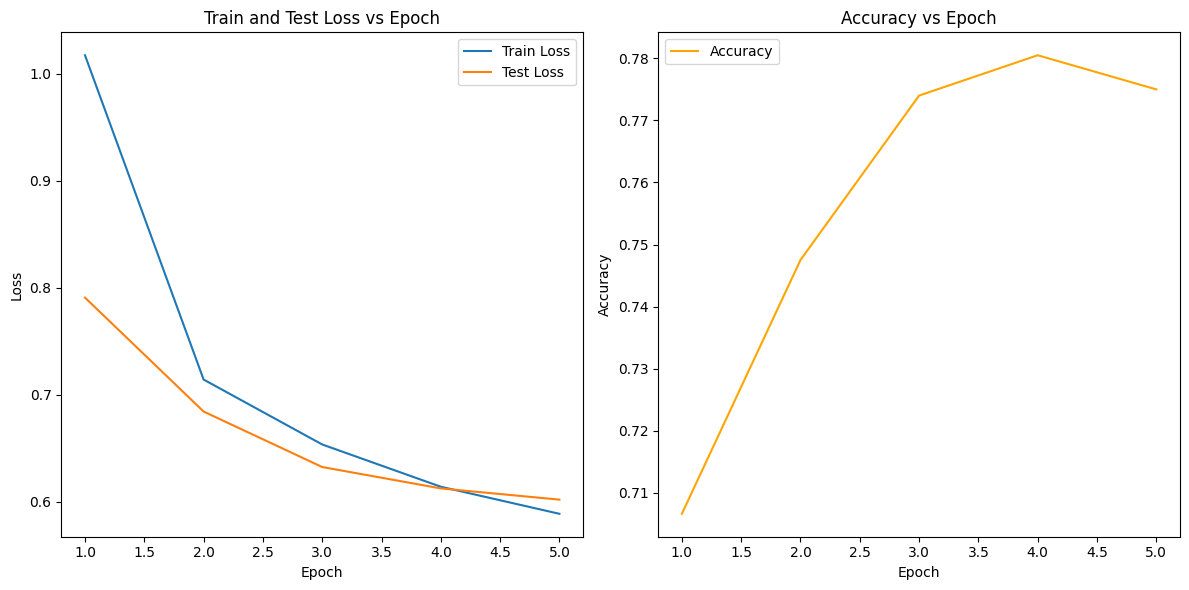

Accuracy: 0.7750
Testing params: {'batch_size': 64, 'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 2}
Epoch: 1, Train loss: 1.1053, Test loss: 0.8651, Accuracy: 0.6770
Epoch: 2, Train loss: 0.7658, Test loss: 0.7667, Accuracy: 0.7220
Epoch: 3, Train loss: 0.6952, Test loss: 0.6822, Accuracy: 0.7548
Epoch: 4, Train loss: 0.6666, Test loss: 0.6632, Accuracy: 0.7558
Epoch: 5, Train loss: 0.6463, Test loss: 0.6546, Accuracy: 0.7630


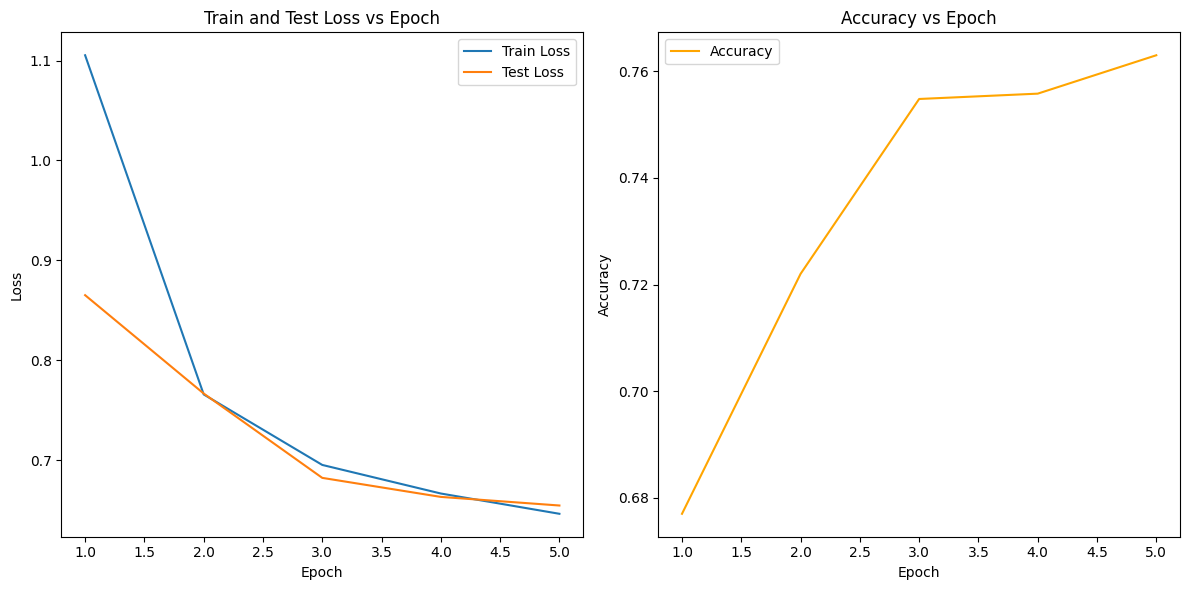

Accuracy: 0.7630
Testing params: {'batch_size': 64, 'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 4}
Epoch: 1, Train loss: 1.0049, Test loss: 0.7660, Accuracy: 0.7073
Epoch: 2, Train loss: 0.6821, Test loss: 0.6632, Accuracy: 0.7583
Epoch: 3, Train loss: 0.6221, Test loss: 0.6114, Accuracy: 0.7827
Epoch: 4, Train loss: 0.5868, Test loss: 0.5744, Accuracy: 0.7939
Epoch: 5, Train loss: 0.5699, Test loss: 0.5869, Accuracy: 0.7902


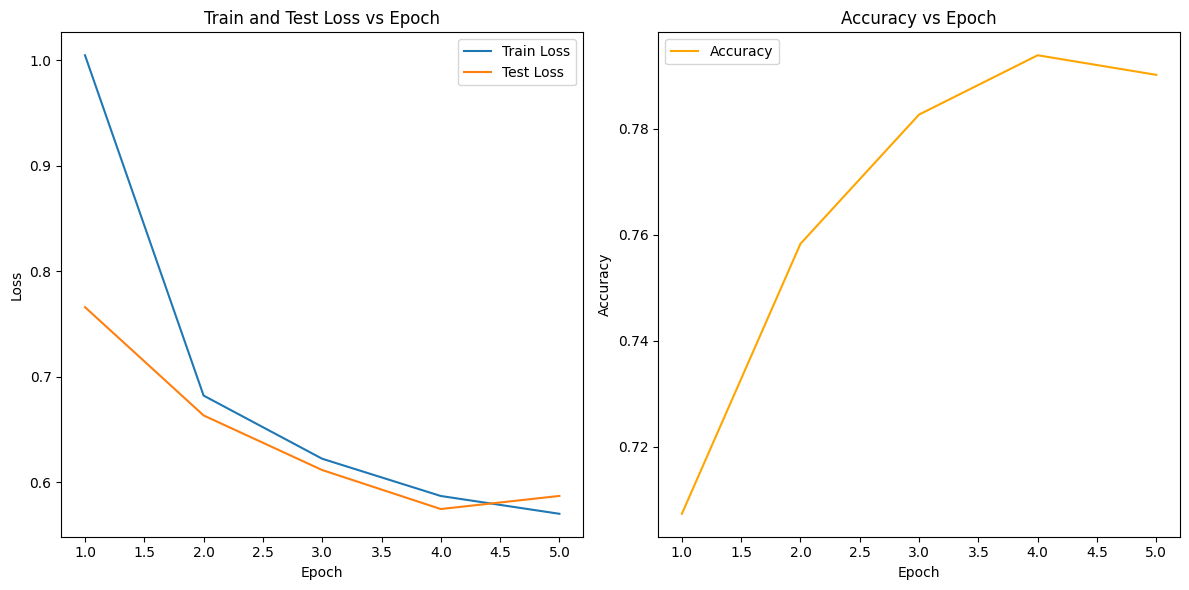

Accuracy: 0.7902
Best params: {'batch_size': 64, 'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 4}, Best accuracy: 0.7902
Grid Search Results:
Params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 2}, Accuracy: 0.2568
Params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 4}, Accuracy: 0.3107
Params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 2}, Accuracy: 0.2650
Params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 4}, Accuracy: 0.3810
Params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 2}, Accuracy: 0.2408
Params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 4}, Accuracy: 0.3629
Params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 128, 'num_hi

In [ ]:
from itertools import product

# Hyperparameter space
param_grid = {
    "batch_size": [32, 64],
    "lr": [1e-2, 1e-3],
    "hidden_size": [64, 128],
    "num_hidden_layers": [4, 6],
    "num_attention_heads": [2, 4]
}

# Prepare Fashion MNIST dataset
def prepare_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

# Grid Search implementation
def grid_search(param_grid):
    best_accuracy = 0
    best_params = None
    results = []

    # Iterate over all parameter combinations
    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        print(f"Testing params: {current_params}")

        # Update config with current parameters
        config.update({
            "hidden_size": current_params["hidden_size"],
            "num_hidden_layers": current_params["num_hidden_layers"],
            "num_attention_heads": current_params["num_attention_heads"]
        })
        assert config["hidden_size"] % config["num_attention_heads"] == 0  # Validity check

        trainloader, testloader = prepare_data(batch_size=current_params["batch_size"])
        model = ViTForClassification(config).to(device)
        optimizer = AdamW(model.parameters(), lr=current_params["lr"], weight_decay=1e-2)
        loss_fn = nn.CrossEntropyLoss()
        trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)

        # Train for a reduced number of epochs for speed
        trainer.train(trainloader, testloader, epochs=5, save_model_every_n_epochs=0)

        # Evaluate final accuracy
        accuracy, _ = trainer.evaluate(testloader)
        print(f"Accuracy: {accuracy:.4f}")

        results.append((current_params, accuracy))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = current_params

    print(f"Best params: {best_params}, Best accuracy: {best_accuracy:.4f}")
    return best_params, results

# Main function to perform grid search
def main():
    best_params, results = grid_search(param_grid)
    print("Grid Search Results:")
    for params, acc in results:
        print(f"Params: {params}, Accuracy: {acc:.4f}")

if __name__ == '__main__':
    main()


MNIST with hyperparameter tuning

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import AdamW
import os
import matplotlib.pyplot as plt



In [ ]:

import torchvision
import torchvision.transforms as transforms


def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),

        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=train_transform)
    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),  # Optional resizing
        transforms.Normalize((0.5,), (0.5,))  # Normalize for grayscale
    ])

    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=test_transform)
    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)

    classes = tuple(str(i) for i in range(10))  # Classes for MNIST are digits 0-9
    return trainloader, testloader, classes


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
import json, os, math
import matplotlib.pyplot as plt
import numpy as np

from torch.nn import functional as F



def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies


def visualize_images():
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
    classes = tuple(str(i) for i in range(10))  # Classes for MNIST: digits 0-9

    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]

    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')
        ax.set_title(classes[labels[i]])


@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images.
    """
    model.eval()
    # Load random images
    num_images = 30
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)
    classes = tuple(str(i) for i in range(10))  # Classes for MNIST: digits 0-9

    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5,), (0.5,))  # Grayscale normalization
    ])
    images = torch.stack([test_transform(image) for image in raw_images])

    images = images.to(device)
    model = model.to(device)

    logits, attention_maps = model(images, output_attentions=True)

    predictions = torch.argmax(logits, dim=1)

    attention_maps = torch.cat(attention_maps, dim=1)

    attention_maps = attention_maps[:, :, 0, 1:]

    attention_maps = attention_maps.mean(dim=1)

    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)

    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img, cmap='gray')

        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask == 1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')

        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt == pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()


Testing parameters: {'lr': 0.001, 'hidden_size': 32, 'num_hidden_layers': 2, 'num_attention_heads': 2, 'epochs': 5}
Epoch: 1, Train loss: 1.6471, Test loss: 1.4314, Accuracy: 0.5031
Epoch: 2, Train loss: 1.4392, Test loss: 1.4277, Accuracy: 0.5186
Epoch: 3, Train loss: 1.3603, Test loss: 1.3536, Accuracy: 0.5252
Epoch: 4, Train loss: 1.3117, Test loss: 1.2792, Accuracy: 0.5637
Epoch: 5, Train loss: 1.2807, Test loss: 1.2686, Accuracy: 0.5733


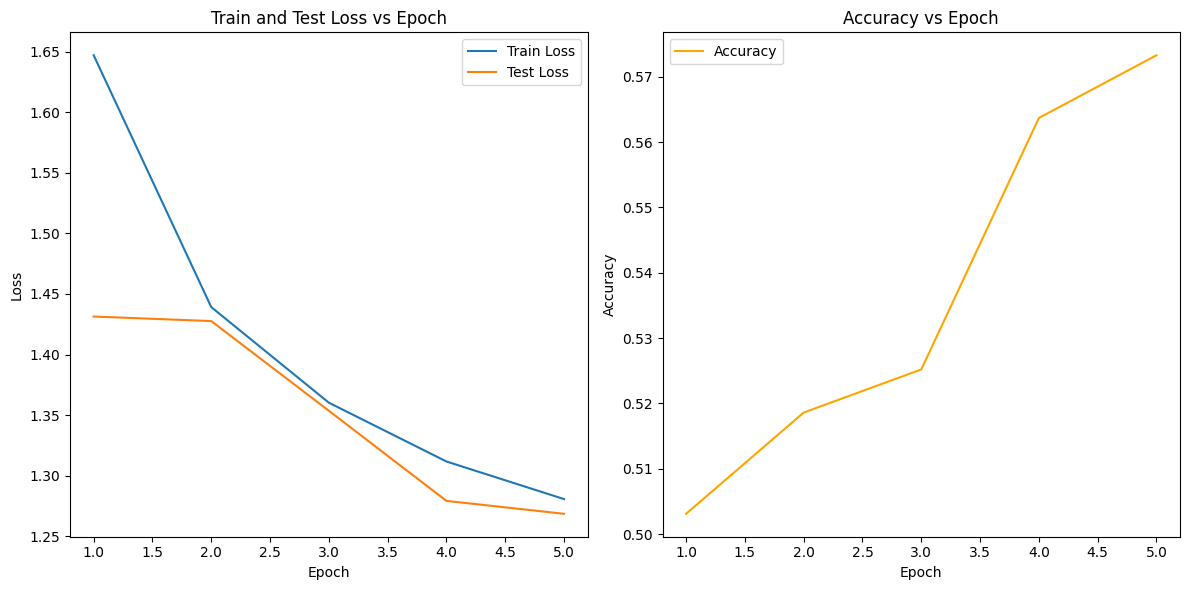

Accuracy for {'lr': 0.001, 'hidden_size': 32, 'num_hidden_layers': 2, 'num_attention_heads': 2, 'epochs': 5}: 0.5733
Testing parameters: {'lr': 0.001, 'hidden_size': 32, 'num_hidden_layers': 2, 'num_attention_heads': 4, 'epochs': 5}
Epoch: 1, Train loss: 1.6140, Test loss: 1.3010, Accuracy: 0.5518
Epoch: 2, Train loss: 1.2567, Test loss: 1.1651, Accuracy: 0.6095
Epoch: 3, Train loss: 1.1403, Test loss: 1.0700, Accuracy: 0.6436
Epoch: 4, Train loss: 1.0721, Test loss: 1.0440, Accuracy: 0.6544
Epoch: 5, Train loss: 1.0356, Test loss: 1.0013, Accuracy: 0.6708


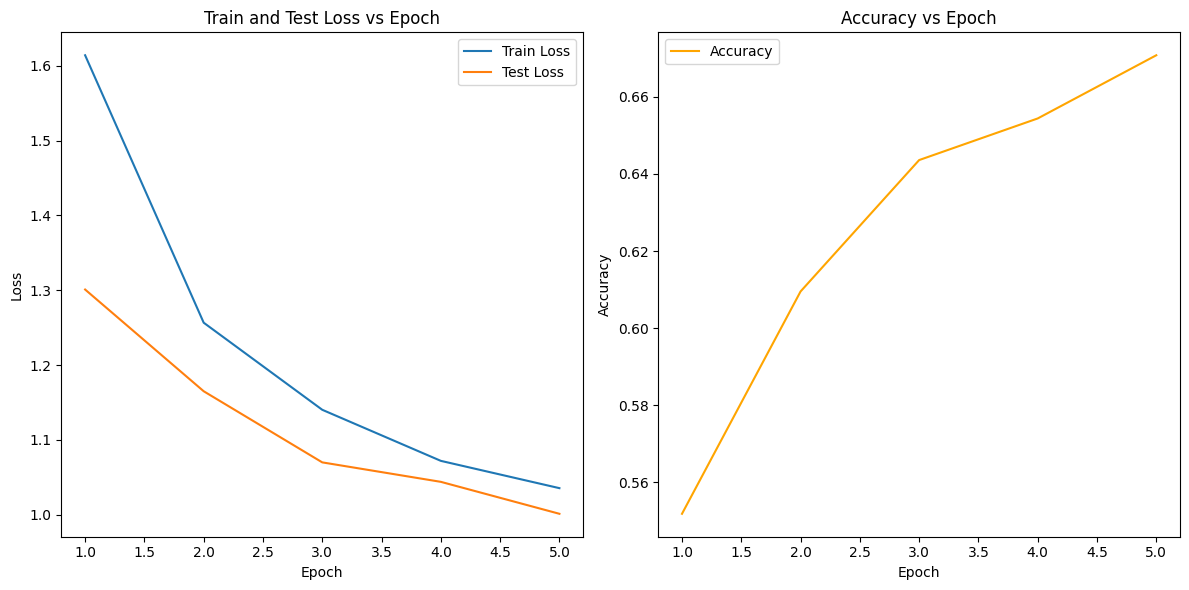

Accuracy for {'lr': 0.001, 'hidden_size': 32, 'num_hidden_layers': 2, 'num_attention_heads': 4, 'epochs': 5}: 0.6708
Testing parameters: {'lr': 0.001, 'hidden_size': 32, 'num_hidden_layers': 4, 'num_attention_heads': 2, 'epochs': 5}
Epoch: 1, Train loss: 1.7350, Test loss: 1.4762, Accuracy: 0.4885
Epoch: 2, Train loss: 1.4300, Test loss: 1.3951, Accuracy: 0.5186
Epoch: 3, Train loss: 1.3427, Test loss: 1.2966, Accuracy: 0.5503
Epoch: 4, Train loss: 1.2830, Test loss: 1.2293, Accuracy: 0.5784
Epoch: 5, Train loss: 1.2468, Test loss: 1.1832, Accuracy: 0.6008


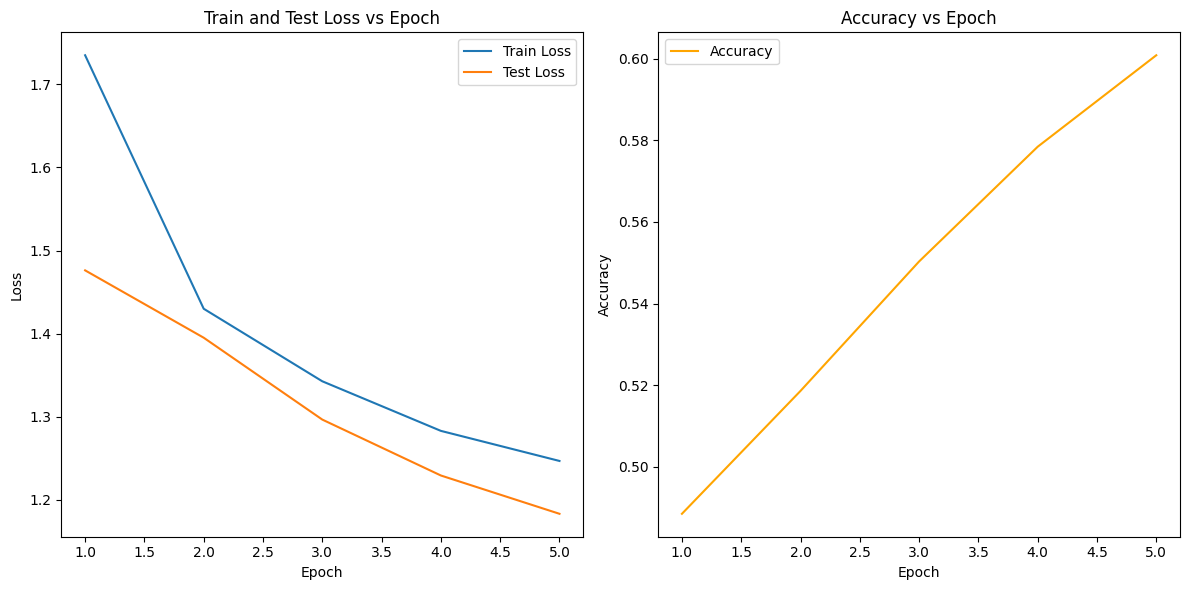

Accuracy for {'lr': 0.001, 'hidden_size': 32, 'num_hidden_layers': 4, 'num_attention_heads': 2, 'epochs': 5}: 0.6008
Testing parameters: {'lr': 0.001, 'hidden_size': 32, 'num_hidden_layers': 4, 'num_attention_heads': 4, 'epochs': 5}
Epoch: 1, Train loss: 1.5433, Test loss: 1.2777, Accuracy: 0.5596
Epoch: 2, Train loss: 1.2218, Test loss: 1.1681, Accuracy: 0.6013
Epoch: 3, Train loss: 1.1236, Test loss: 1.2163, Accuracy: 0.5933
Epoch: 4, Train loss: 1.0567, Test loss: 1.0634, Accuracy: 0.6450
Epoch: 5, Train loss: 1.0201, Test loss: 1.0094, Accuracy: 0.6623


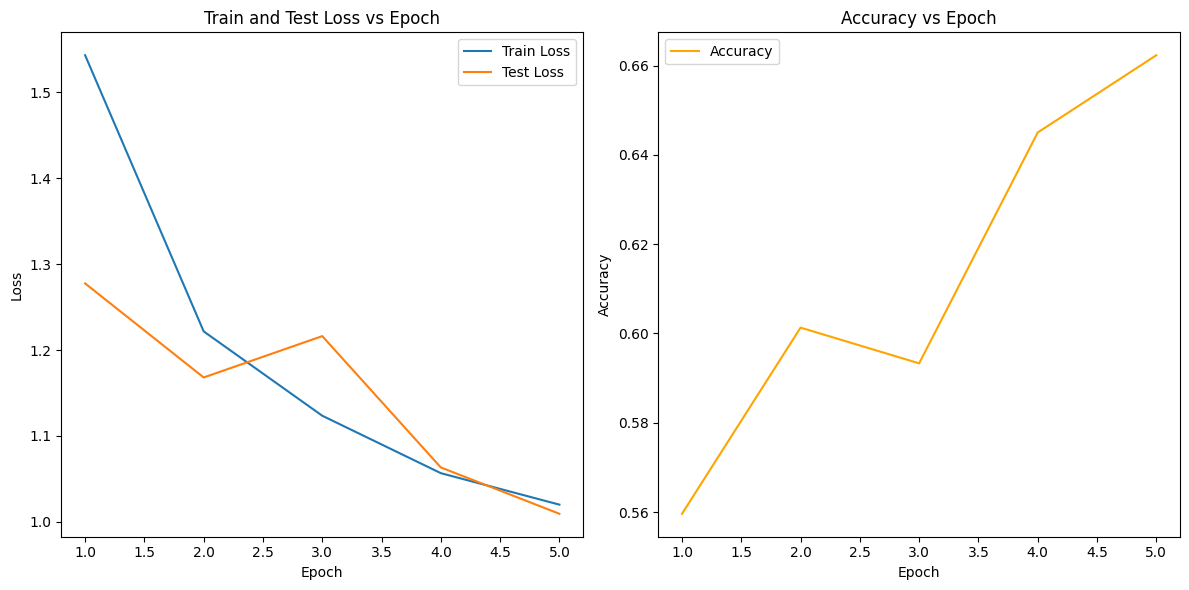

Accuracy for {'lr': 0.001, 'hidden_size': 32, 'num_hidden_layers': 4, 'num_attention_heads': 4, 'epochs': 5}: 0.6623
Testing parameters: {'lr': 0.001, 'hidden_size': 32, 'num_hidden_layers': 6, 'num_attention_heads': 2, 'epochs': 5}
Epoch: 1, Train loss: 1.6638, Test loss: 1.3998, Accuracy: 0.5151
Epoch: 2, Train loss: 1.3662, Test loss: 1.3111, Accuracy: 0.5326
Epoch: 3, Train loss: 1.2994, Test loss: 1.2330, Accuracy: 0.5852
Epoch: 4, Train loss: 1.2583, Test loss: 1.2347, Accuracy: 0.5708
Epoch: 5, Train loss: 1.2329, Test loss: 1.1971, Accuracy: 0.5897


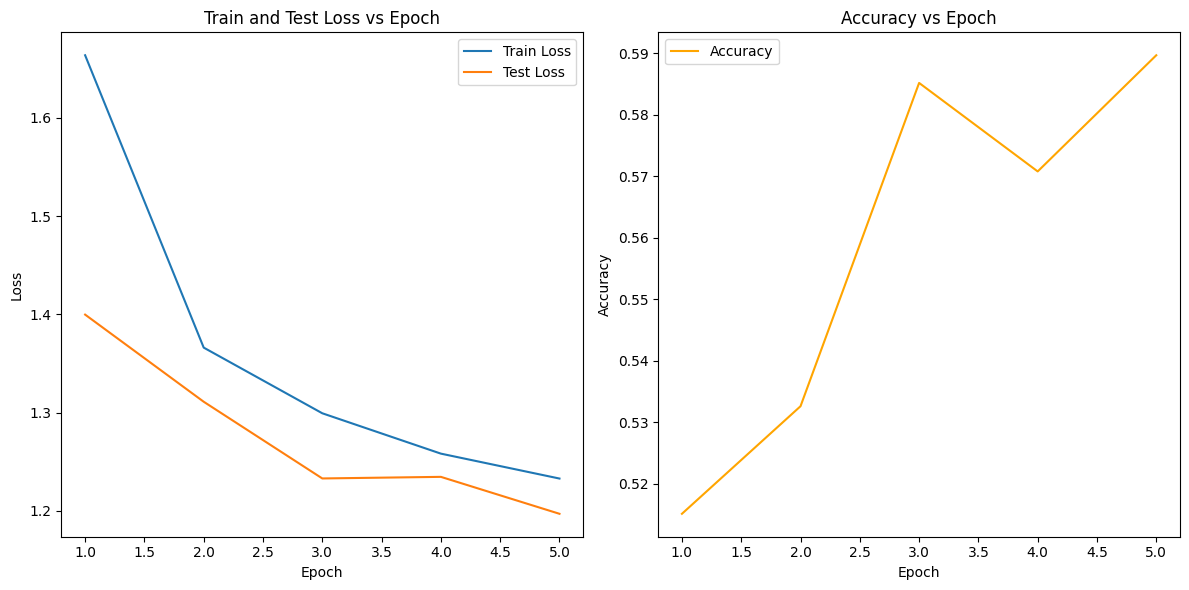

Accuracy for {'lr': 0.001, 'hidden_size': 32, 'num_hidden_layers': 6, 'num_attention_heads': 2, 'epochs': 5}: 0.5897
Testing parameters: {'lr': 0.001, 'hidden_size': 32, 'num_hidden_layers': 6, 'num_attention_heads': 4, 'epochs': 5}
Epoch: 1, Train loss: 1.5515, Test loss: 1.3115, Accuracy: 0.5445
Epoch: 2, Train loss: 1.2208, Test loss: 1.1292, Accuracy: 0.6138
Epoch: 3, Train loss: 1.1321, Test loss: 1.1396, Accuracy: 0.6105
Epoch: 4, Train loss: 1.0715, Test loss: 1.0602, Accuracy: 0.6400
Epoch: 5, Train loss: 1.0288, Test loss: 1.0149, Accuracy: 0.6584


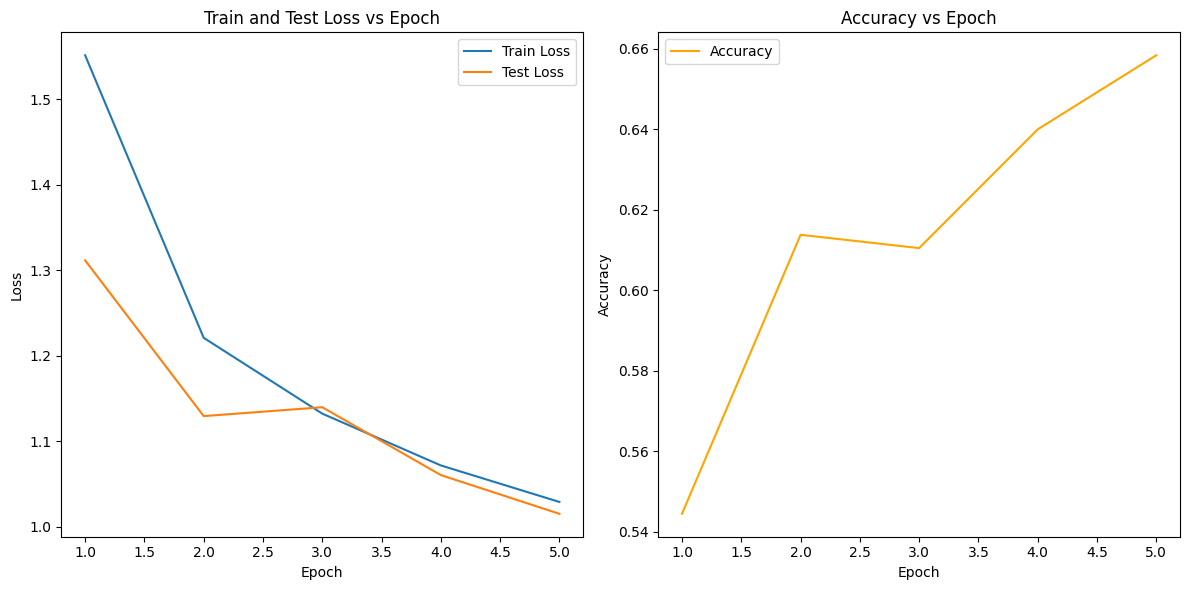

Accuracy for {'lr': 0.001, 'hidden_size': 32, 'num_hidden_layers': 6, 'num_attention_heads': 4, 'epochs': 5}: 0.6584
Testing parameters: {'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 2, 'num_attention_heads': 2, 'epochs': 5}
Epoch: 1, Train loss: 1.6150, Test loss: 1.4126, Accuracy: 0.5101
Epoch: 2, Train loss: 1.3710, Test loss: 1.2955, Accuracy: 0.5624
Epoch: 3, Train loss: 1.2999, Test loss: 1.2206, Accuracy: 0.5849
Epoch: 4, Train loss: 1.2662, Test loss: 1.2011, Accuracy: 0.5969
Epoch: 5, Train loss: 1.2430, Test loss: 1.1940, Accuracy: 0.5926


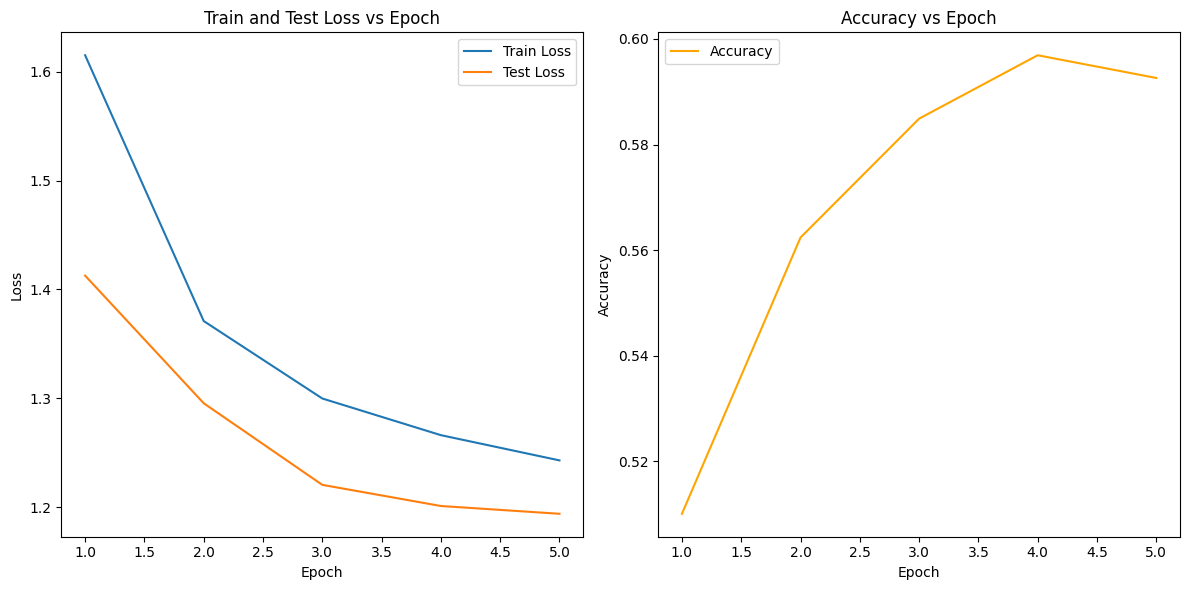

Accuracy for {'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 2, 'num_attention_heads': 2, 'epochs': 5}: 0.5926
Testing parameters: {'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 2, 'num_attention_heads': 4, 'epochs': 5}
Epoch: 1, Train loss: 1.4857, Test loss: 1.2082, Accuracy: 0.5947
Epoch: 2, Train loss: 1.1898, Test loss: 1.1000, Accuracy: 0.6255
Epoch: 3, Train loss: 1.0812, Test loss: 1.0581, Accuracy: 0.6452
Epoch: 4, Train loss: 1.0387, Test loss: 0.9816, Accuracy: 0.6731
Epoch: 5, Train loss: 1.0109, Test loss: 0.9722, Accuracy: 0.6800


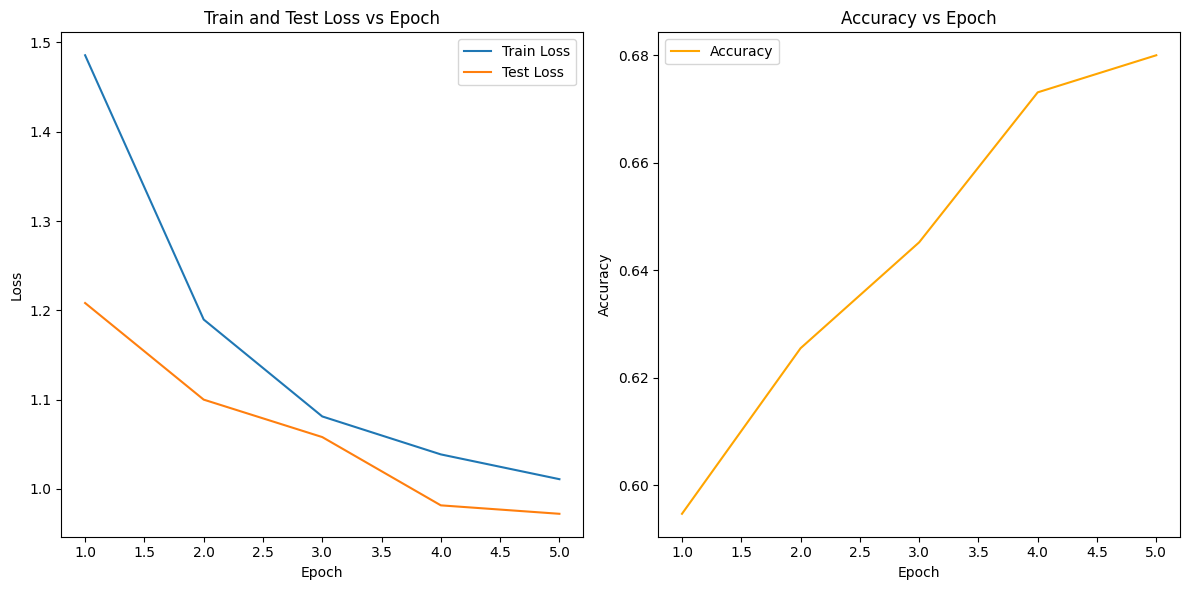

Accuracy for {'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 2, 'num_attention_heads': 4, 'epochs': 5}: 0.6800
Testing parameters: {'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 2, 'epochs': 5}
Epoch: 1, Train loss: 1.6460, Test loss: 1.3904, Accuracy: 0.5211
Epoch: 2, Train loss: 1.4315, Test loss: 1.4126, Accuracy: 0.5232
Epoch: 3, Train loss: 1.3980, Test loss: 1.4531, Accuracy: 0.5075
Epoch: 4, Train loss: 1.3642, Test loss: 1.3783, Accuracy: 0.5354
Epoch: 5, Train loss: 1.3437, Test loss: 1.2751, Accuracy: 0.5630


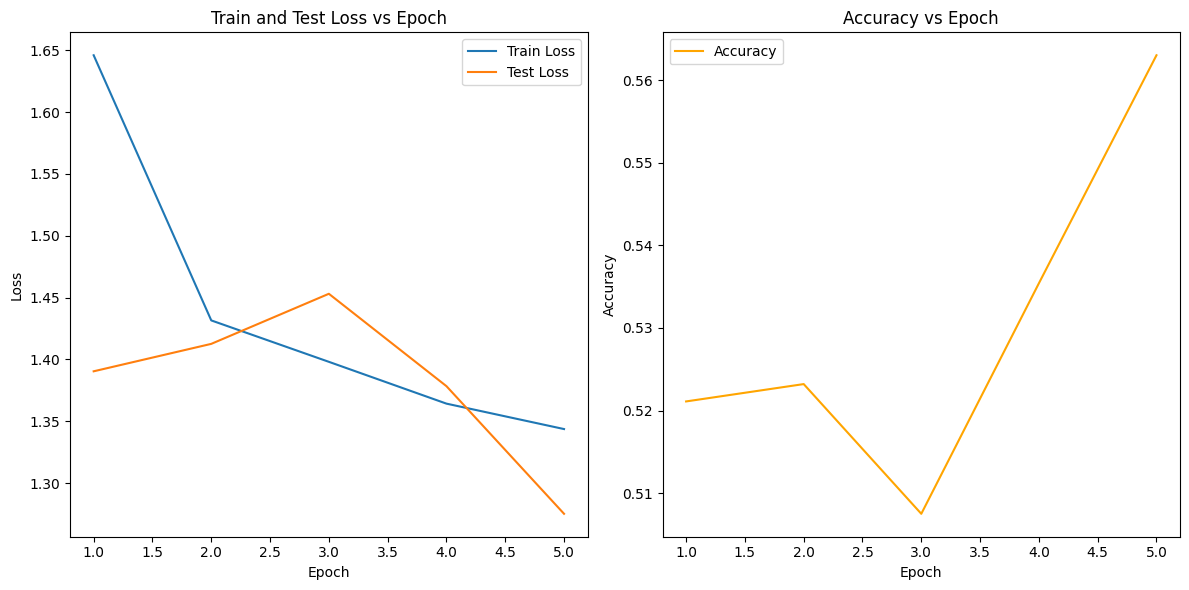

Accuracy for {'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 2, 'epochs': 5}: 0.5630
Testing parameters: {'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 4, 'epochs': 5}
Epoch: 1, Train loss: 1.4848, Test loss: 1.2761, Accuracy: 0.5631
Epoch: 2, Train loss: 1.2379, Test loss: 1.1563, Accuracy: 0.6054
Epoch: 3, Train loss: 1.1689, Test loss: 1.1267, Accuracy: 0.6177
Epoch: 4, Train loss: 1.1137, Test loss: 1.0917, Accuracy: 0.6287
Epoch: 5, Train loss: 1.0874, Test loss: 1.0329, Accuracy: 0.6529


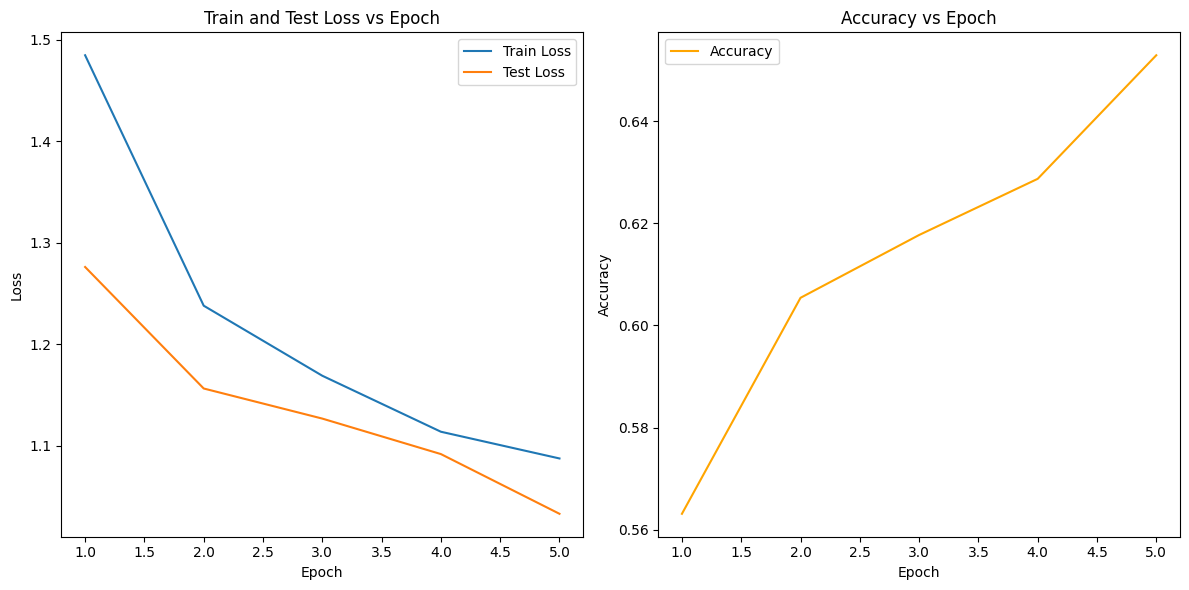

Accuracy for {'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 4, 'epochs': 5}: 0.6529
Testing parameters: {'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 2, 'epochs': 5}
Epoch: 1, Train loss: 1.6367, Test loss: 1.4860, Accuracy: 0.4944
Epoch: 2, Train loss: 1.4252, Test loss: 1.3718, Accuracy: 0.5195
Epoch: 3, Train loss: 1.3662, Test loss: 1.3264, Accuracy: 0.5511
Epoch: 4, Train loss: 1.3305, Test loss: 1.2951, Accuracy: 0.5559
Epoch: 5, Train loss: 1.3045, Test loss: 1.3327, Accuracy: 0.5460


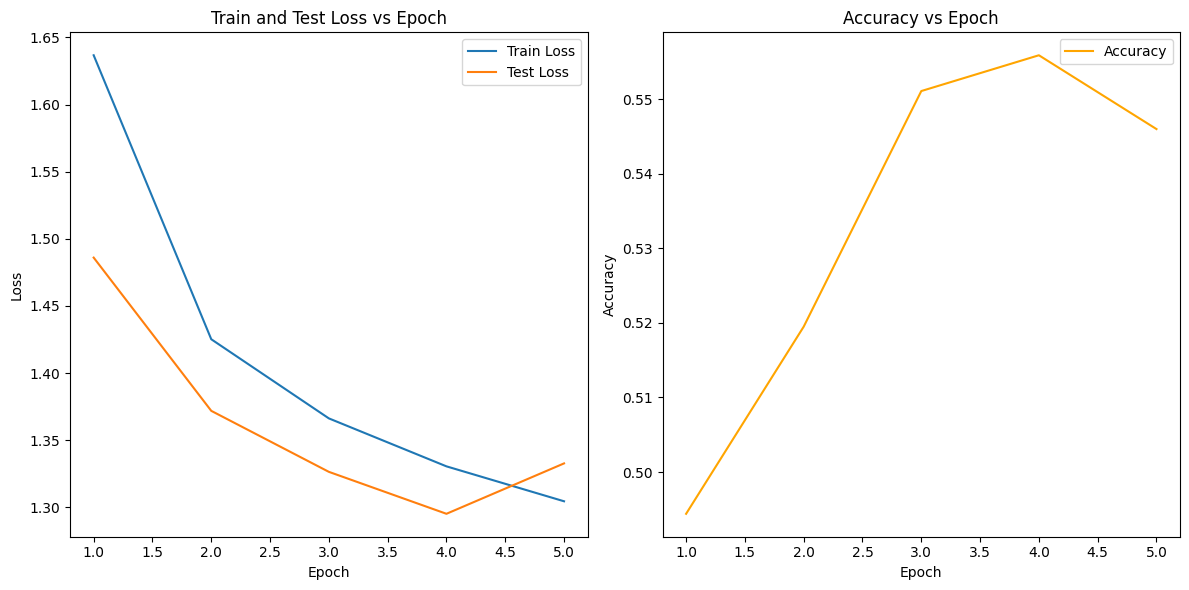

Accuracy for {'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 2, 'epochs': 5}: 0.5460
Testing parameters: {'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 4, 'epochs': 5}
Epoch: 1, Train loss: 1.4572, Test loss: 1.2556, Accuracy: 0.5582
Epoch: 2, Train loss: 1.1981, Test loss: 1.1016, Accuracy: 0.6272
Epoch: 3, Train loss: 1.1154, Test loss: 1.0895, Accuracy: 0.6297
Epoch: 4, Train loss: 1.0663, Test loss: 0.9968, Accuracy: 0.6651
Epoch: 5, Train loss: 1.0395, Test loss: 1.0026, Accuracy: 0.6663


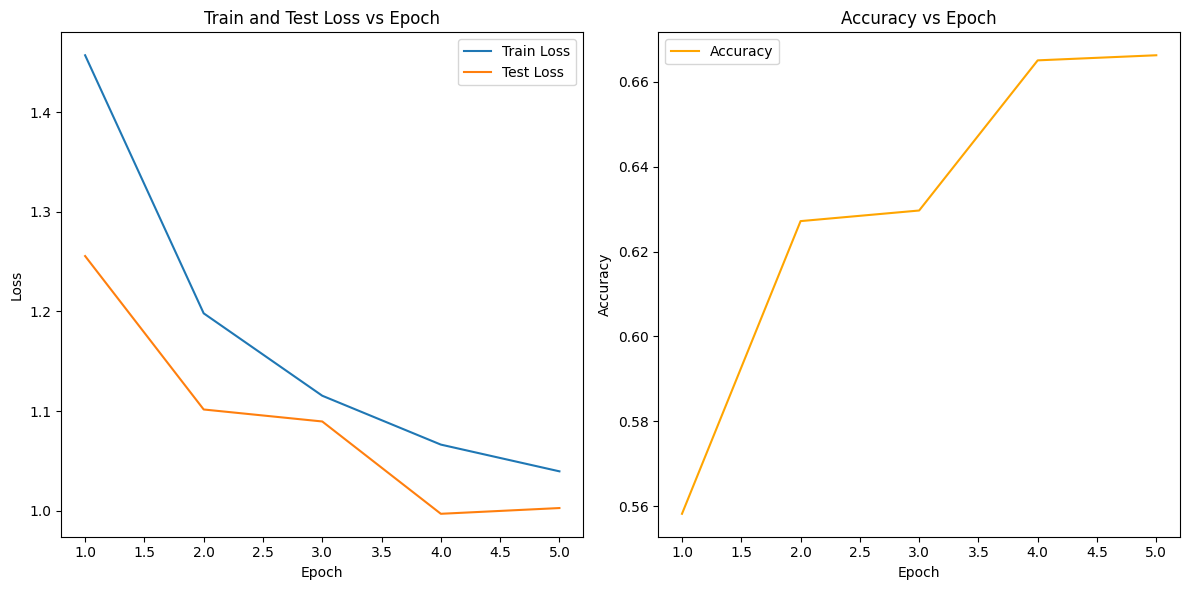

Accuracy for {'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 4, 'epochs': 5}: 0.6663
Testing parameters: {'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 2, 'num_attention_heads': 2, 'epochs': 5}
Epoch: 1, Train loss: 1.7127, Test loss: 1.6435, Accuracy: 0.4227
Epoch: 2, Train loss: 1.5911, Test loss: 1.6384, Accuracy: 0.4317
Epoch: 3, Train loss: 1.6007, Test loss: 1.5479, Accuracy: 0.4533
Epoch: 4, Train loss: 1.6032, Test loss: 1.5897, Accuracy: 0.4518
Epoch: 5, Train loss: 1.6057, Test loss: 1.6250, Accuracy: 0.4358


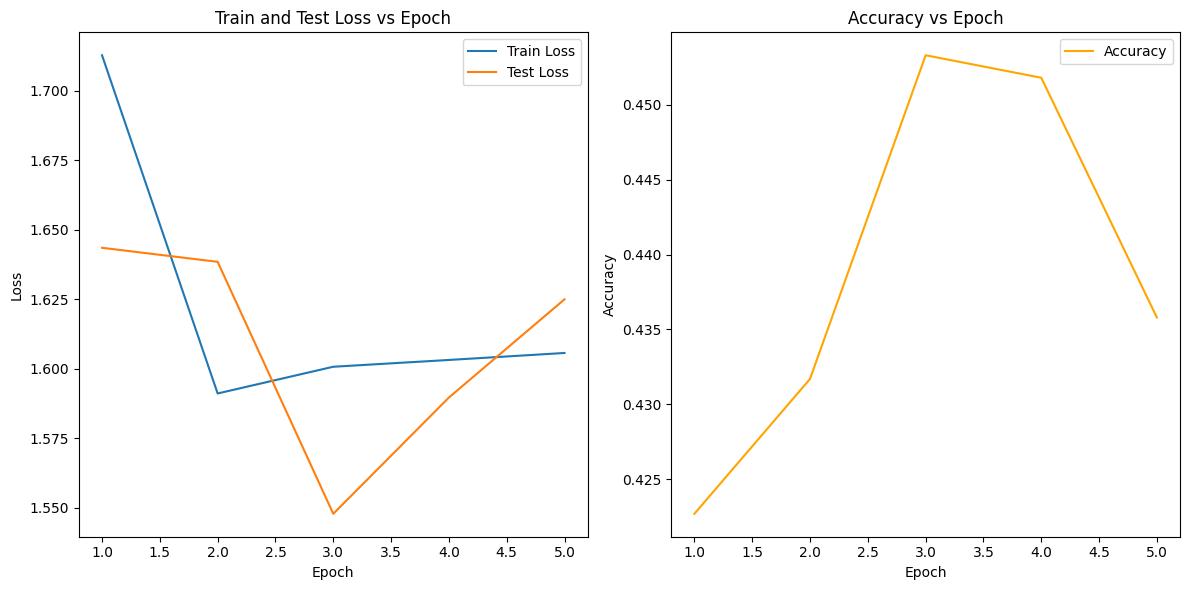

Accuracy for {'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 2, 'num_attention_heads': 2, 'epochs': 5}: 0.4358
Testing parameters: {'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 2, 'num_attention_heads': 4, 'epochs': 5}
Epoch: 1, Train loss: 1.5438, Test loss: 1.3066, Accuracy: 0.5522
Epoch: 2, Train loss: 1.3758, Test loss: 1.3430, Accuracy: 0.5368
Epoch: 3, Train loss: 1.3601, Test loss: 1.3053, Accuracy: 0.5361
Epoch: 4, Train loss: 1.3491, Test loss: 1.4182, Accuracy: 0.5179
Epoch: 5, Train loss: 1.3936, Test loss: 1.3371, Accuracy: 0.5380


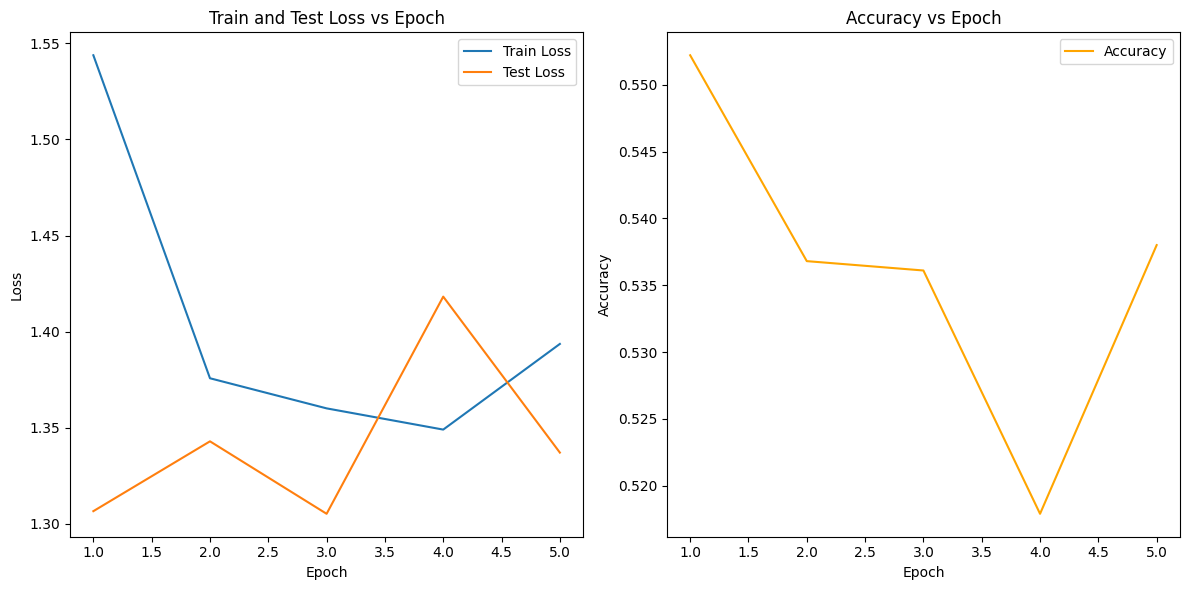

Accuracy for {'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 2, 'num_attention_heads': 4, 'epochs': 5}: 0.5380
Testing parameters: {'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 2, 'epochs': 5}
Epoch: 1, Train loss: 1.7427, Test loss: 1.5677, Accuracy: 0.4511
Epoch: 2, Train loss: 1.6261, Test loss: 1.5831, Accuracy: 0.4473
Epoch: 3, Train loss: 1.5863, Test loss: 1.6028, Accuracy: 0.4328
Epoch: 4, Train loss: 1.5943, Test loss: 1.6421, Accuracy: 0.4127
Epoch: 5, Train loss: 1.6359, Test loss: 1.6316, Accuracy: 0.4277


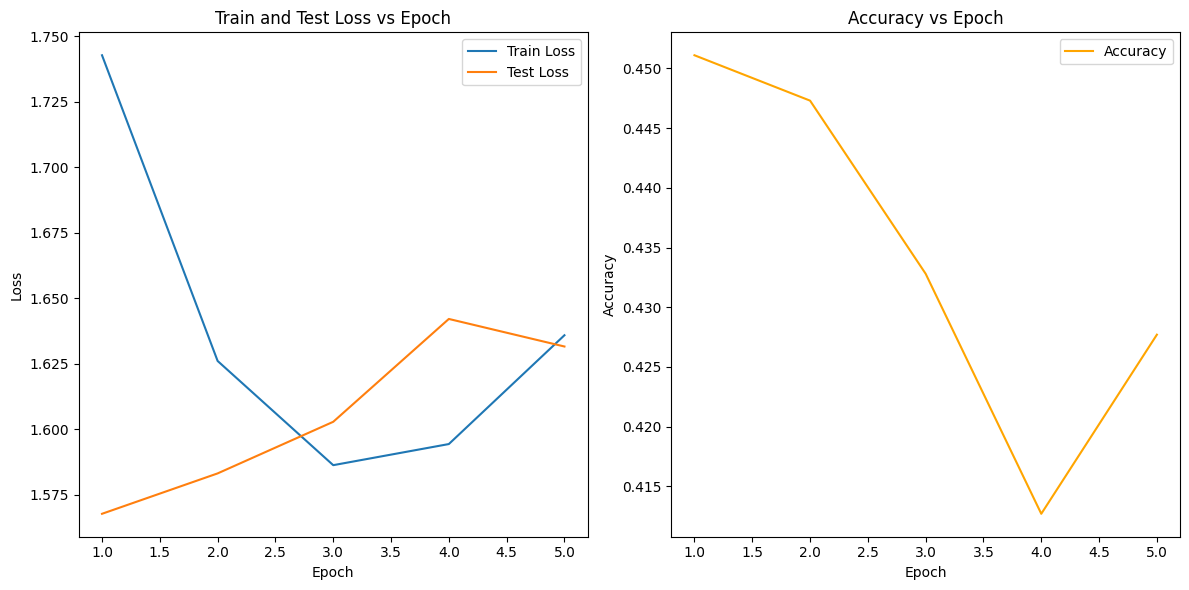

Accuracy for {'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 2, 'epochs': 5}: 0.4277
Testing parameters: {'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 4, 'epochs': 5}
Epoch: 1, Train loss: 1.5521, Test loss: 1.3504, Accuracy: 0.5368
Epoch: 2, Train loss: 1.4046, Test loss: 1.3822, Accuracy: 0.5276
Epoch: 3, Train loss: 1.3884, Test loss: 1.3847, Accuracy: 0.5217
Epoch: 4, Train loss: 1.4034, Test loss: 1.3088, Accuracy: 0.5522
Epoch: 5, Train loss: 1.3953, Test loss: 1.3575, Accuracy: 0.5380


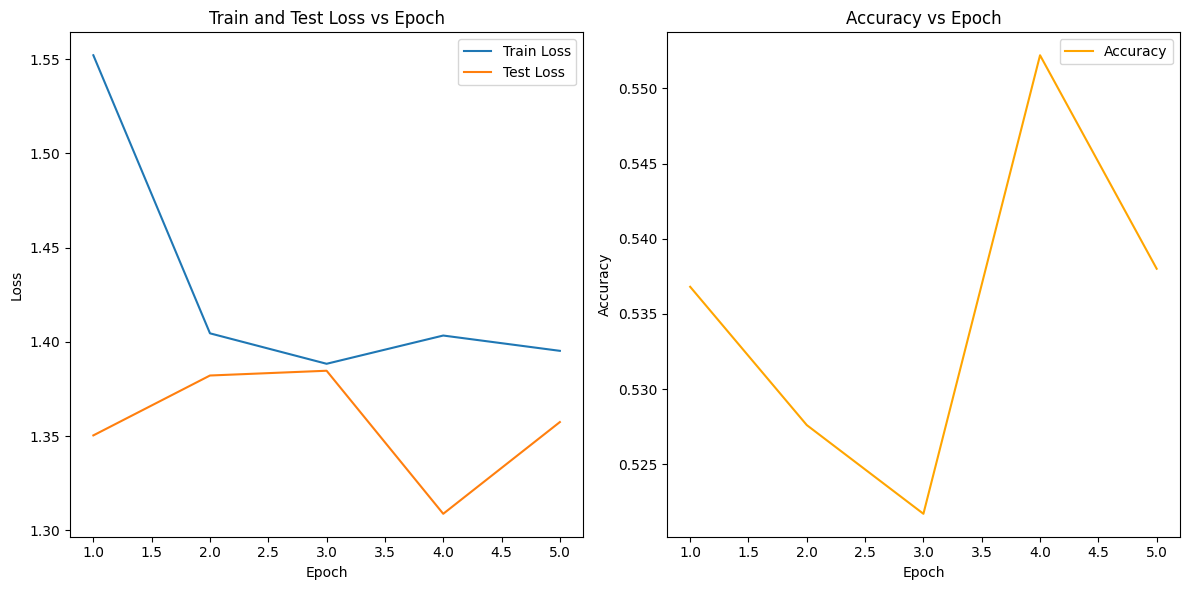

Accuracy for {'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 4, 'epochs': 5}: 0.5380
Testing parameters: {'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 2, 'epochs': 5}
Epoch: 1, Train loss: 1.7185, Test loss: 1.5729, Accuracy: 0.4420
Epoch: 2, Train loss: 1.6192, Test loss: 1.5716, Accuracy: 0.4529
Epoch: 3, Train loss: 1.6082, Test loss: 1.6442, Accuracy: 0.4357
Epoch: 4, Train loss: 1.6227, Test loss: 1.7386, Accuracy: 0.3945
Epoch: 5, Train loss: 1.6254, Test loss: 1.6309, Accuracy: 0.4280


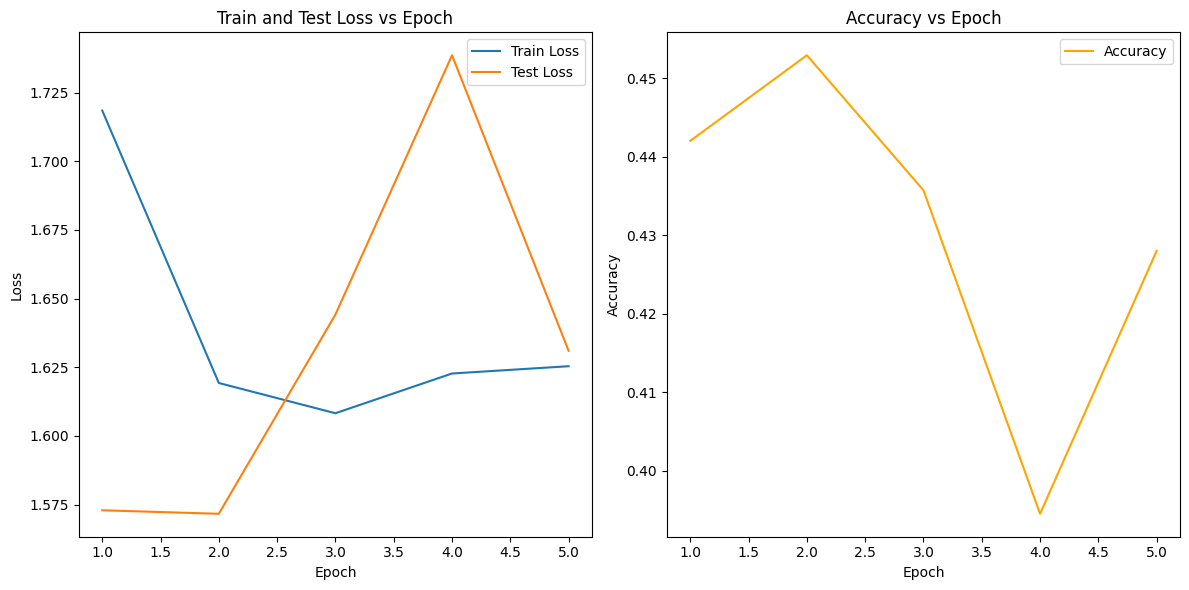

Accuracy for {'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 2, 'epochs': 5}: 0.4280
Testing parameters: {'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 4, 'epochs': 5}
Epoch: 1, Train loss: 1.5493, Test loss: 1.5143, Accuracy: 0.4556
Epoch: 2, Train loss: 1.3920, Test loss: 1.3809, Accuracy: 0.5161
Epoch: 3, Train loss: 1.3671, Test loss: 1.3929, Accuracy: 0.5160
Epoch: 4, Train loss: 1.3733, Test loss: 1.3671, Accuracy: 0.5331
Epoch: 5, Train loss: 1.3766, Test loss: 1.5285, Accuracy: 0.4912


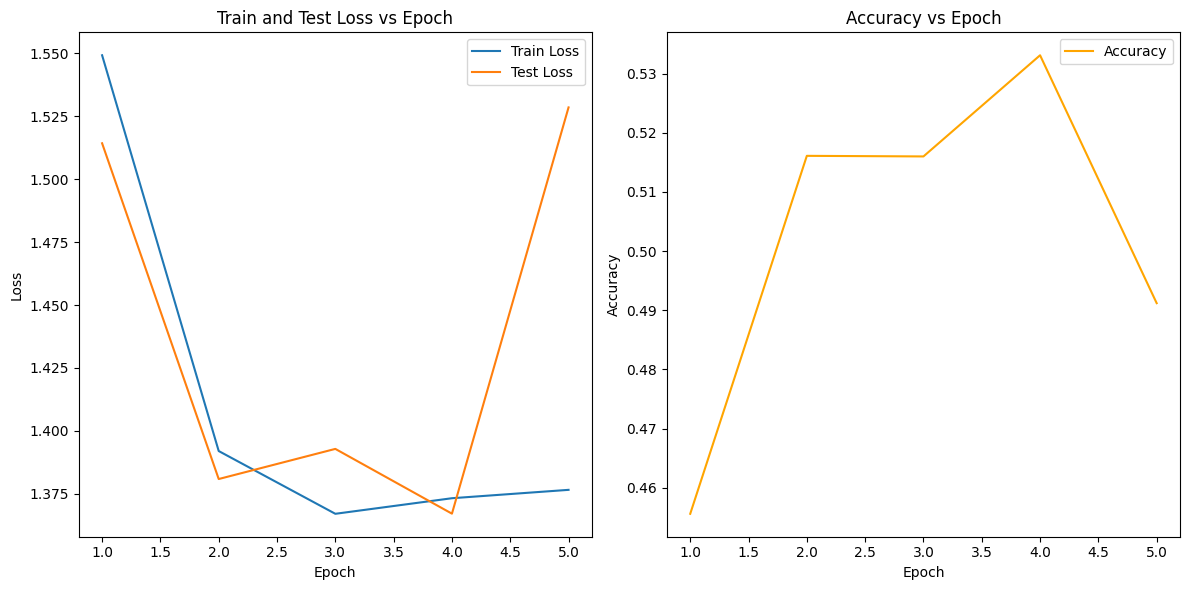

Accuracy for {'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 4, 'epochs': 5}: 0.4912
Testing parameters: {'lr': 0.01, 'hidden_size': 32, 'num_hidden_layers': 2, 'num_attention_heads': 2, 'epochs': 5}
Epoch: 1, Train loss: 2.3681, Test loss: 2.3766, Accuracy: 0.1049
Epoch: 2, Train loss: 2.3519, Test loss: 2.3023, Accuracy: 0.1159
Epoch: 3, Train loss: 2.3520, Test loss: 2.6421, Accuracy: 0.1130
Epoch: 4, Train loss: 2.3579, Test loss: 2.4098, Accuracy: 0.1386
Epoch: 5, Train loss: 2.3596, Test loss: 2.3220, Accuracy: 0.1062


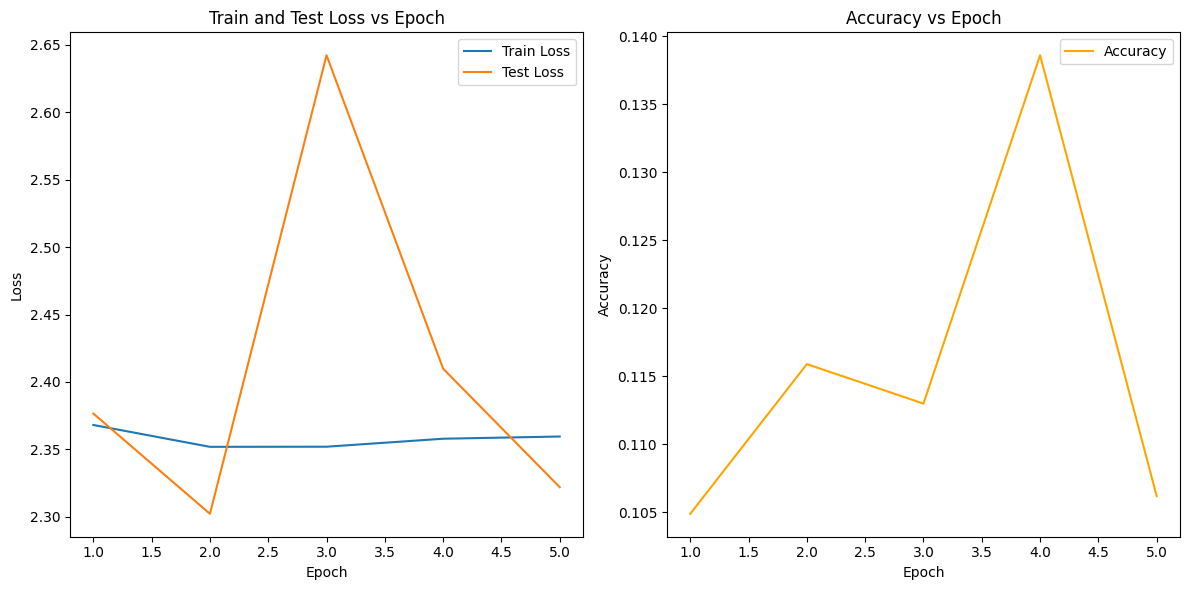

Accuracy for {'lr': 0.01, 'hidden_size': 32, 'num_hidden_layers': 2, 'num_attention_heads': 2, 'epochs': 5}: 0.1062
Testing parameters: {'lr': 0.01, 'hidden_size': 32, 'num_hidden_layers': 2, 'num_attention_heads': 4, 'epochs': 5}
Epoch: 1, Train loss: 2.3237, Test loss: 2.1547, Accuracy: 0.1713
Epoch: 2, Train loss: 2.3362, Test loss: 2.3638, Accuracy: 0.1157
Epoch: 3, Train loss: 2.3446, Test loss: 2.3074, Accuracy: 0.1294
Epoch: 4, Train loss: 2.3523, Test loss: 2.2203, Accuracy: 0.2049
Epoch: 5, Train loss: 2.3356, Test loss: 2.3294, Accuracy: 0.1342


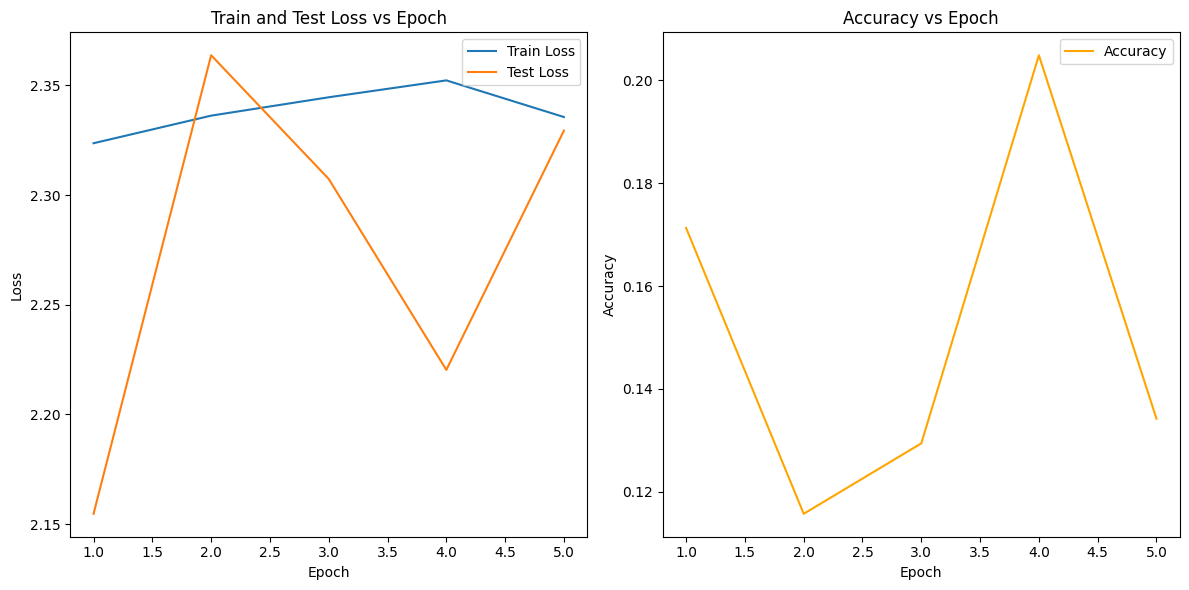

Accuracy for {'lr': 0.01, 'hidden_size': 32, 'num_hidden_layers': 2, 'num_attention_heads': 4, 'epochs': 5}: 0.1342
Testing parameters: {'lr': 0.01, 'hidden_size': 32, 'num_hidden_layers': 4, 'num_attention_heads': 2, 'epochs': 5}
Epoch: 1, Train loss: 2.3640, Test loss: 2.3010, Accuracy: 0.1112
Epoch: 2, Train loss: 2.3472, Test loss: 2.3589, Accuracy: 0.1009
Epoch: 3, Train loss: 2.3492, Test loss: 2.4654, Accuracy: 0.0975
Epoch: 4, Train loss: 2.3443, Test loss: 2.3208, Accuracy: 0.1275
Epoch: 5, Train loss: 2.3426, Test loss: 2.3010, Accuracy: 0.1525


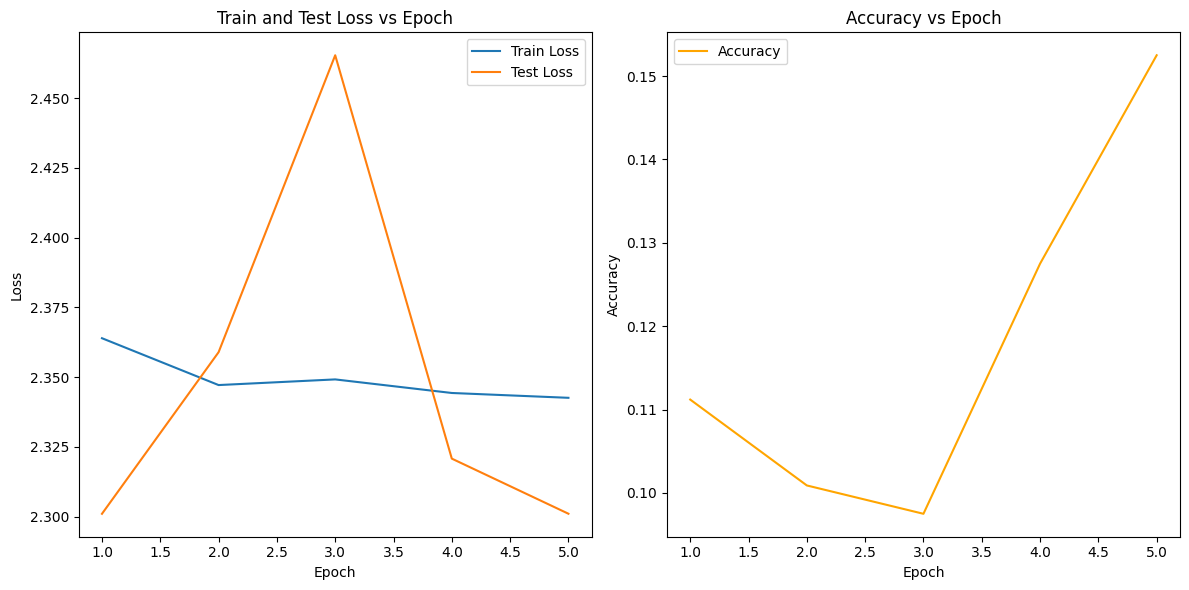

Accuracy for {'lr': 0.01, 'hidden_size': 32, 'num_hidden_layers': 4, 'num_attention_heads': 2, 'epochs': 5}: 0.1525
Testing parameters: {'lr': 0.01, 'hidden_size': 32, 'num_hidden_layers': 4, 'num_attention_heads': 4, 'epochs': 5}
Epoch: 1, Train loss: 2.3488, Test loss: 2.2442, Accuracy: 0.1621
Epoch: 2, Train loss: 2.3263, Test loss: 2.3172, Accuracy: 0.1565
Epoch: 3, Train loss: 2.3557, Test loss: 2.3757, Accuracy: 0.0895
Epoch: 4, Train loss: 2.3478, Test loss: 2.2940, Accuracy: 0.1306
Epoch: 5, Train loss: 2.3457, Test loss: 2.3208, Accuracy: 0.1236


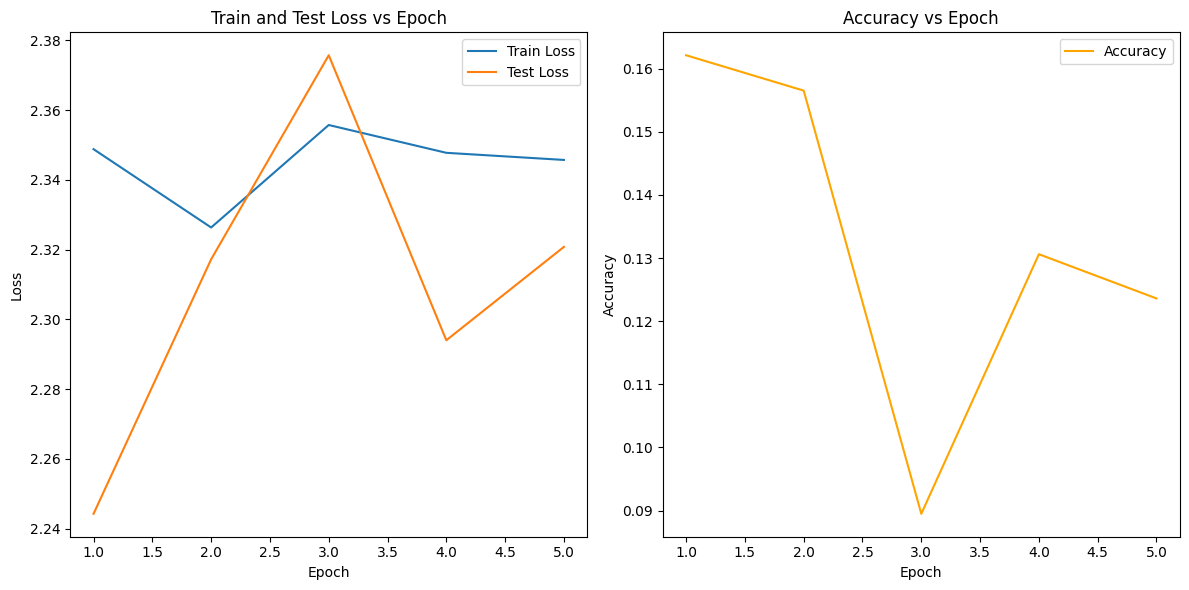

Accuracy for {'lr': 0.01, 'hidden_size': 32, 'num_hidden_layers': 4, 'num_attention_heads': 4, 'epochs': 5}: 0.1236
Testing parameters: {'lr': 0.01, 'hidden_size': 32, 'num_hidden_layers': 6, 'num_attention_heads': 2, 'epochs': 5}
Epoch: 1, Train loss: 2.3420, Test loss: 2.2026, Accuracy: 0.1878
Epoch: 2, Train loss: 2.3299, Test loss: 2.2480, Accuracy: 0.1672
Epoch: 3, Train loss: 2.3256, Test loss: 2.3201, Accuracy: 0.1045
Epoch: 4, Train loss: 2.3514, Test loss: 2.2703, Accuracy: 0.1709
Epoch: 5, Train loss: 2.3374, Test loss: 2.3685, Accuracy: 0.1118


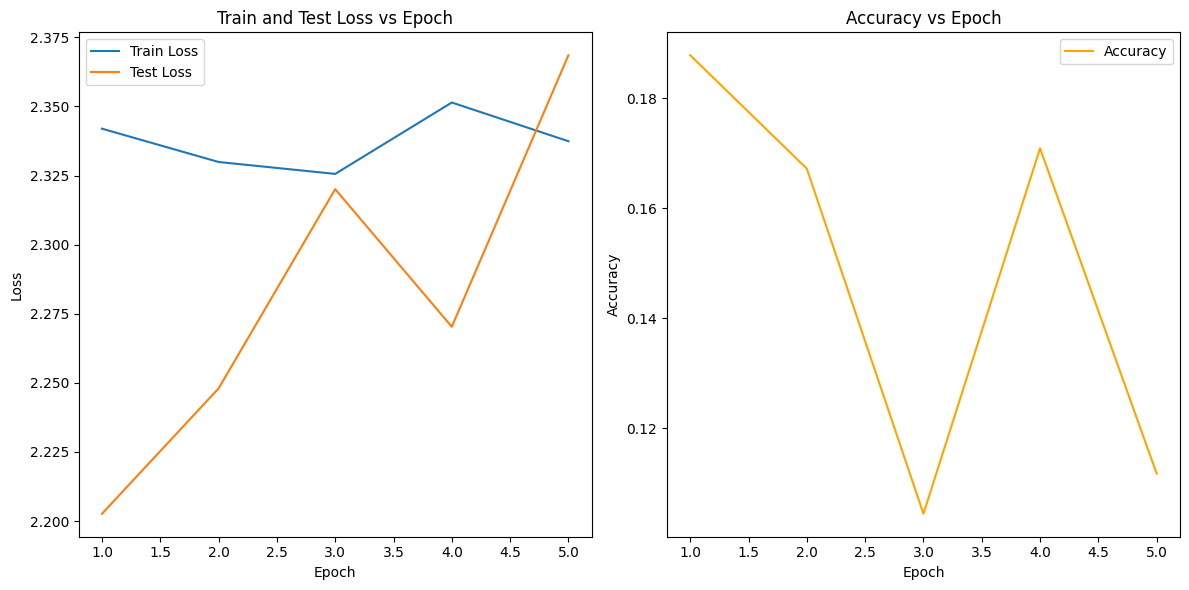

Accuracy for {'lr': 0.01, 'hidden_size': 32, 'num_hidden_layers': 6, 'num_attention_heads': 2, 'epochs': 5}: 0.1118
Testing parameters: {'lr': 0.01, 'hidden_size': 32, 'num_hidden_layers': 6, 'num_attention_heads': 4, 'epochs': 5}
Epoch: 1, Train loss: 2.3474, Test loss: 2.3743, Accuracy: 0.1372
Epoch: 2, Train loss: 2.3282, Test loss: 2.6635, Accuracy: 0.1472
Epoch: 3, Train loss: 2.3256, Test loss: 2.2510, Accuracy: 0.1732
Epoch: 4, Train loss: 2.2908, Test loss: 2.3255, Accuracy: 0.1236
Epoch: 5, Train loss: 2.3348, Test loss: 2.4369, Accuracy: 0.1784


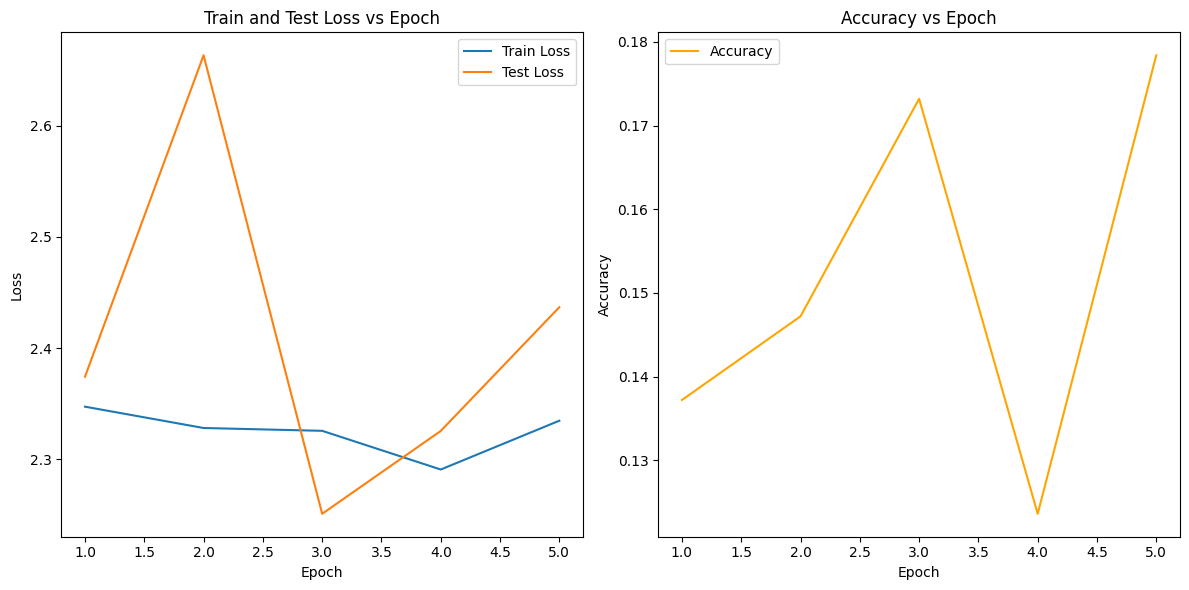

Accuracy for {'lr': 0.01, 'hidden_size': 32, 'num_hidden_layers': 6, 'num_attention_heads': 4, 'epochs': 5}: 0.1784
Testing parameters: {'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 2, 'num_attention_heads': 2, 'epochs': 5}
Epoch: 1, Train loss: 2.5938, Test loss: 2.3486, Accuracy: 0.1198
Epoch: 2, Train loss: 2.6185, Test loss: 2.6612, Accuracy: 0.0854
Epoch: 3, Train loss: 3.0040, Test loss: 14.2262, Accuracy: 0.1066
Epoch: 4, Train loss: 2.4597, Test loss: 2.2914, Accuracy: 0.1320
Epoch: 5, Train loss: 2.7879, Test loss: 2.2974, Accuracy: 0.1427


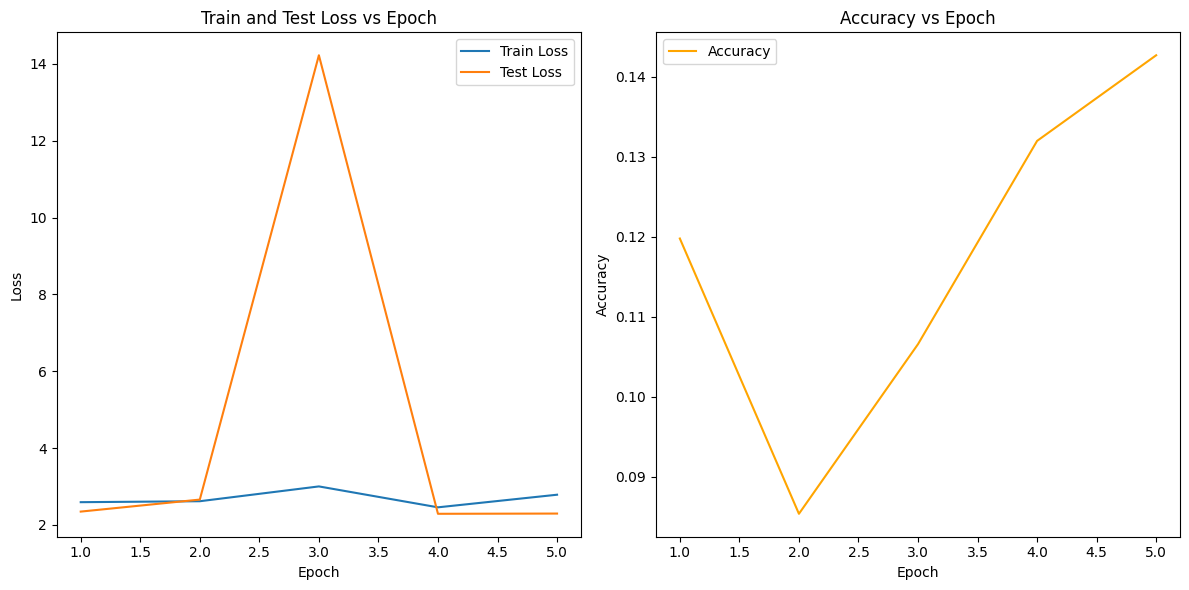

Accuracy for {'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 2, 'num_attention_heads': 2, 'epochs': 5}: 0.1427
Testing parameters: {'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 2, 'num_attention_heads': 4, 'epochs': 5}


In [ ]:
from itertools import product

def hyperparameter_tuning(config, hyperparams, trainloader, testloader, device):
    """
    Perform hyperparameter tuning with grid search.
    """
    best_accuracy = 0
    best_params = None
    results = []

    keys, values = zip(*hyperparams.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    for params in param_combinations:

        print(f"Testing parameters: {params}")
        for key, value in params.items():
            if key in config:
                config[key] = value


        model = ViTForClassification(config).to(device)
        optimizer = AdamW(model.parameters(), lr=params['lr'], weight_decay=params.get('weight_decay', 1e-2))
        loss_fn = nn.CrossEntropyLoss()

        trainer = Trainer(model, optimizer, loss_fn, exp_name=f"gridsearch_{params}", device=device)
        trainer.train(trainloader, testloader, epochs=params.get('epochs', 5), save_model_every_n_epochs=0)


        final_accuracy = trainer.accuracies[-1]
        results.append((params, final_accuracy))

        if final_accuracy > best_accuracy:
            best_accuracy = final_accuracy
            best_params = params

        print(f"Accuracy for {params}: {final_accuracy:.4f}")

    print("\nBest Parameters:", best_params)
    print("Best Accuracy:", best_accuracy)
    return best_params, results

#  hyperparameters
hyperparams = {
    "lr": [1e-3, 1e-2, 1e-1],
    "hidden_size": [32, 64, 128],
    "num_hidden_layers": [2, 4, 6],
    "num_attention_heads": [2, 4],
    "epochs": [5],
}


trainloader, testloader = prepare_data(batch_size=batch_size)


best_params, all_results = hyperparameter_tuning(config, hyperparams, trainloader, testloader, device)


print("All Results:")
for params, accuracy in all_results:
    print(f"Params: {params}, Accuracy: {accuracy:.4f}")


CIFAR 10 with hyperparameter tuning

In [ ]:
from itertools import product
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torch.nn as nn

# Hyperparameter space
param_grid = {
    "batch_size": [32, 64],
    "lr": [1e-2, 1e-3],
    "hidden_size": [64, 128],
    "num_hidden_layers": [4],
    "num_attention_heads": [2]
}


default_config = {
    "image_size": 32,  # CIFAR-10 images are 32x32
    "patch_size": 4,
    "num_classes": 10,
    "hidden_size": 64,
    "num_hidden_layers": 4,
    "num_attention_heads": 2,
    "mlp_dim": 128,
    "dropout_rate": 0.1
}


def prepare_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

def grid_search(param_grid, config):
    best_accuracy = 0
    best_params = None
    results = []


    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        print(f"Testing params: {current_params}")

        config.update({
            "hidden_size": current_params["hidden_size"],
            "num_hidden_layers": current_params["num_hidden_layers"],
            "num_attention_heads": current_params["num_attention_heads"]
        })
        assert config["hidden_size"] % config["num_attention_heads"] == 0  # Validity check

        trainloader, testloader = prepare_data(batch_size=current_params["batch_size"])
        model = ViTForClassification(config).to(device)
        optimizer = AdamW(model.parameters(), lr=current_params["lr"], weight_decay=1e-2)
        loss_fn = nn.CrossEntropyLoss()
        trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)

        # Train for a reduced number of epochs for speed
        trainer.train(trainloader, testloader, epochs=3, save_model_every_n_epochs=0)

        # Evaluate final accuracy
        accuracy, _ = trainer.evaluate(testloader)
        print(f"Accuracy: {accuracy:.4f}")

        results.append((current_params, accuracy))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = current_params

    print(f"Best params: {best_params}, Best accuracy: {best_accuracy:.4f}")
    return best_params, results


def main():
    best_params, results = grid_search(param_grid, default_config)
    print("Grid Search Results:")
    for params, acc in results:
        print(f"Params: {params}, Accuracy: {acc:.4f}")

if __name__ == '__main__':
    main()


Testing params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 2}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/3, Loss: 2.1676
Epoch 2/3, Loss: 2.1127
Epoch 3/3, Loss: 2.1126
Accuracy: 0.2039
Accuracy: 0.2039
Testing params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 2}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/3, Loss: 2.1501
Epoch 2/3, Loss: 2.1692
Epoch 3/3, Loss: 2.1604
Accuracy: 0.1982
Accuracy: 0.1982
Testing params: {'batch_size': 32, 'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 2}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/3, Loss: 1.7658
Epoch 2/3, Loss: 1.5240
Epoch 3/3, Loss: 1.4008
Accuracy: 0.5118
Accuracy: 0.5118
Testing params: {'batch_size': 32, 'lr': 0.001, 'hidden_size': 128, 'num_hidden_layers': 4, 'num_attenti

In [ ]:
import matplotlib.pyplot as plt
from itertools import product
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torch.nn as nn

# Hyperparameter space
param_grid = {
    "batch_size": [32, 64],
    "lr": [1e-2, 1e-3],
    "hidden_size": [64, 128],
    "num_hidden_layers": [4],
    "num_attention_heads": [2]
}

default_config = {
    "image_size": 32,  # CIFAR-10 images are 32x32
    "patch_size": 4,
    "num_classes": 10,
    "hidden_size": 64,
    "num_hidden_layers": 4,
    "num_attention_heads": 2,
    "mlp_dim": 128,
    "dropout_rate": 0.1
}

device = "cuda" if torch.cuda.is_available() else "cpu"

def prepare_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

# Grid Search implementation
def grid_search(param_grid, config):
    best_accuracy = 0
    best_params = None
    results = []

    epoch_accuracies = []  # List to store accuracies for each epoch

    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        print(f"Testing params: {current_params}")

        config.update({
            "hidden_size": current_params["hidden_size"],
            "num_hidden_layers": current_params["num_hidden_layers"],
            "num_attention_heads": current_params["num_attention_heads"]
        })
        assert config["hidden_size"] % config["num_attention_heads"] == 0  # Validity check

        trainloader, testloader = prepare_data(batch_size=current_params["batch_size"])
        model = ViTForClassification(config).to(device)
        optimizer = AdamW(model.parameters(), lr=current_params["lr"], weight_decay=1e-2)
        loss_fn = nn.CrossEntropyLoss()
        trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)

        # Train for a reduced number of epochs for speed
        epoch_accs = trainer.train(trainloader, testloader, epochs=3, save_model_every_n_epochs=0)

        # Store the accuracy at each epoch for plotting
        epoch_accuracies.append(epoch_accs)

        # Evaluate final accuracy
        accuracy, _ = trainer.evaluate(testloader)
        print(f"Accuracy: {accuracy:.4f}")

        results.append((current_params, accuracy))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = current_params

    print(f"Best params: {best_params}, Best accuracy: {best_accuracy:.4f}")

    # Plot best accuracy vs epoch
    plot_best_accuracy_vs_epoch(epoch_accuracies)

    return best_params, results

def plot_best_accuracy_vs_epoch(epoch_accuracies):
    plt.figure(figsize=(8, 6))

    # Plot each model's accuracy per epoch
    for i, epoch_acc in enumerate(epoch_accuracies):
        plt.plot(range(1, len(epoch_acc) + 1), epoch_acc, label=f"Model {i+1}")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Best Accuracy vs Epoch")
    plt.legend(loc="best")
    plt.show()

def main():
    best_params, results = grid_search(param_grid, default_config)
    print("Grid Search Results:")
    for params, acc in results:
        print(f"Params: {params}, Accuracy: {acc:.4f}")

if __name__ == '__main__':
    main()


Testing params: {'batch_size': 32, 'lr': 0.01, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 2}
Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 

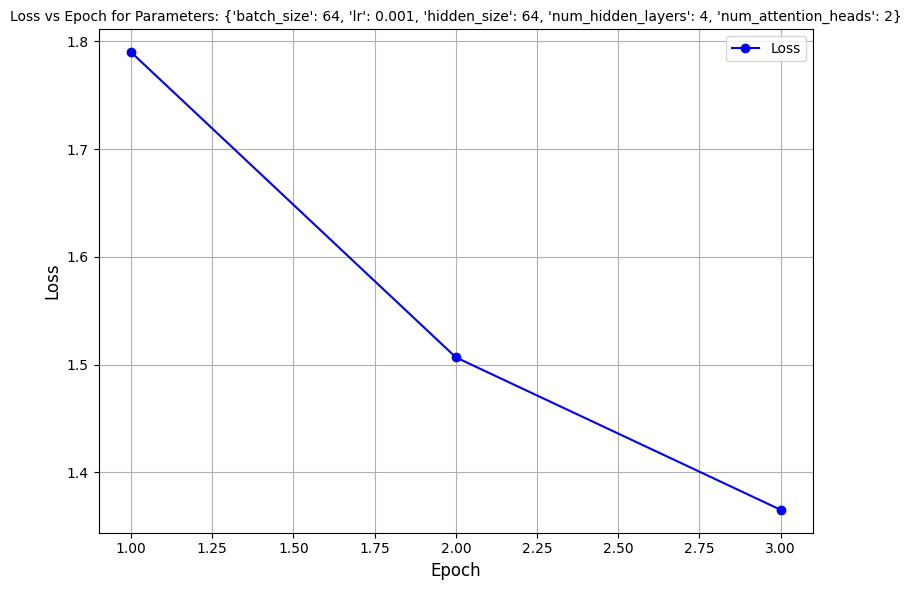

In [ ]:
import matplotlib.pyplot as plt

# Data for epochs and loss values
epochs = [1, 2, 3]
loss_values = [1.7899, 1.5067, 1.3652]

# Plot the loss vs. epoch graph
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label='Loss')

# Adding labels, title, and legend
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title("Loss vs Epoch for Parameters: {'batch_size': 64, 'lr': 0.001, 'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 2}", fontsize=10)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, train_loader, test_loader, epochs, save_model_every_n_epochs=0):
        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch in train_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, labels)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Accuracy: {accuracy:.4f}")
        return accuracy, correct
